# 0.Import data

In [640]:
import pandas as pd
import numpy as np

path_to_train_data = "C:\\data\\UniAdelaideAIML\\data\\assignment2\\train.csv"
path_to_test_data = "C:\\data\\UniAdelaideAIML\\data\\assignment2\\test.csv"
train_data = pd.read_csv(path_to_train_data)
test_data = pd.read_csv(path_to_test_data)

# 1.Inspect the raw data

## 1.1 Check correlation

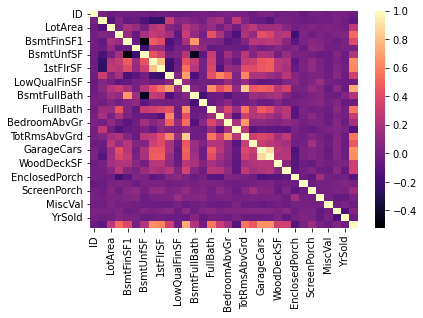

In [691]:
import matplotlib.pyplot as plt # visualization
import seaborn as sb # visualization

sb.heatmap(train_data.corr(), cmap = 'magma')
plt.savefig('raw_train_data_heatmap.png', format='png')
plt.show()

## 1.2 Check data types

In [642]:
# Check data types for categoricals
categoricals_train = set(train_data.dtypes[train_data.dtypes=='object'].index)
categoricals_test = set(train_data.dtypes[train_data.dtypes=='object'].index)

print(categoricals_train-categoricals_test) # Check if categorical sets are different between test and training data. 0 means there are no diffs.
print(categoricals_train) # OverallQual, YearBuilt, OverallCond need to change their dtypes from strings/objects to numerical. See section 2.2.


set()
{'Street', 'ExterQual', 'OverallQual', 'OverallCond', 'BldgType', 'HouseStyle', 'LotConfig', 'YearBuilt'}


## 1.3 Inspect outliers

In [692]:
import matplotlib.pyplot as plt
import math

def plot_custom_subplot(df, y_series, num_cols=int(5), plot_type='scatter', save_fig=False, fig_name=''):
    """Create subplots of each independent variable vs. the dependent variable.

    Args:
        df (pd dataframe): independent variables
        y_series (pd series): dependent variable
        num_cols (int, optional): number of columns in the subplot. Defaults to int(5).
        plot_type (str, optional): Choice of scatter or histogram. Defaults to 'scatter'.
        save_fig (boolean, optional)
        fig_name (str, optional)
    """

    num_plots = len(df.columns)
    num_rows = math.ceil(num_plots/num_cols)
    fig, ax_array =  plt.subplots(num_rows, num_cols, figsize=(100/2.54, 120/2.54), sharey=True)

    k = 0
    for ax_row in ax_array:
        for axes in ax_row:
            axes.set_xlabel(df.columns[k])
            if plot_type == 'scatter':
                axes.scatter(df.iloc[:, k], y_series)
            elif plot_type == 'histogram':
                axes.hist(df.iloc[:, k])
            k += 1
            if k == num_plots:
                break
     
    if save_fig:
        plt.savefig(fig_name + plot_type + '.png', format='png')

    plt.show()   

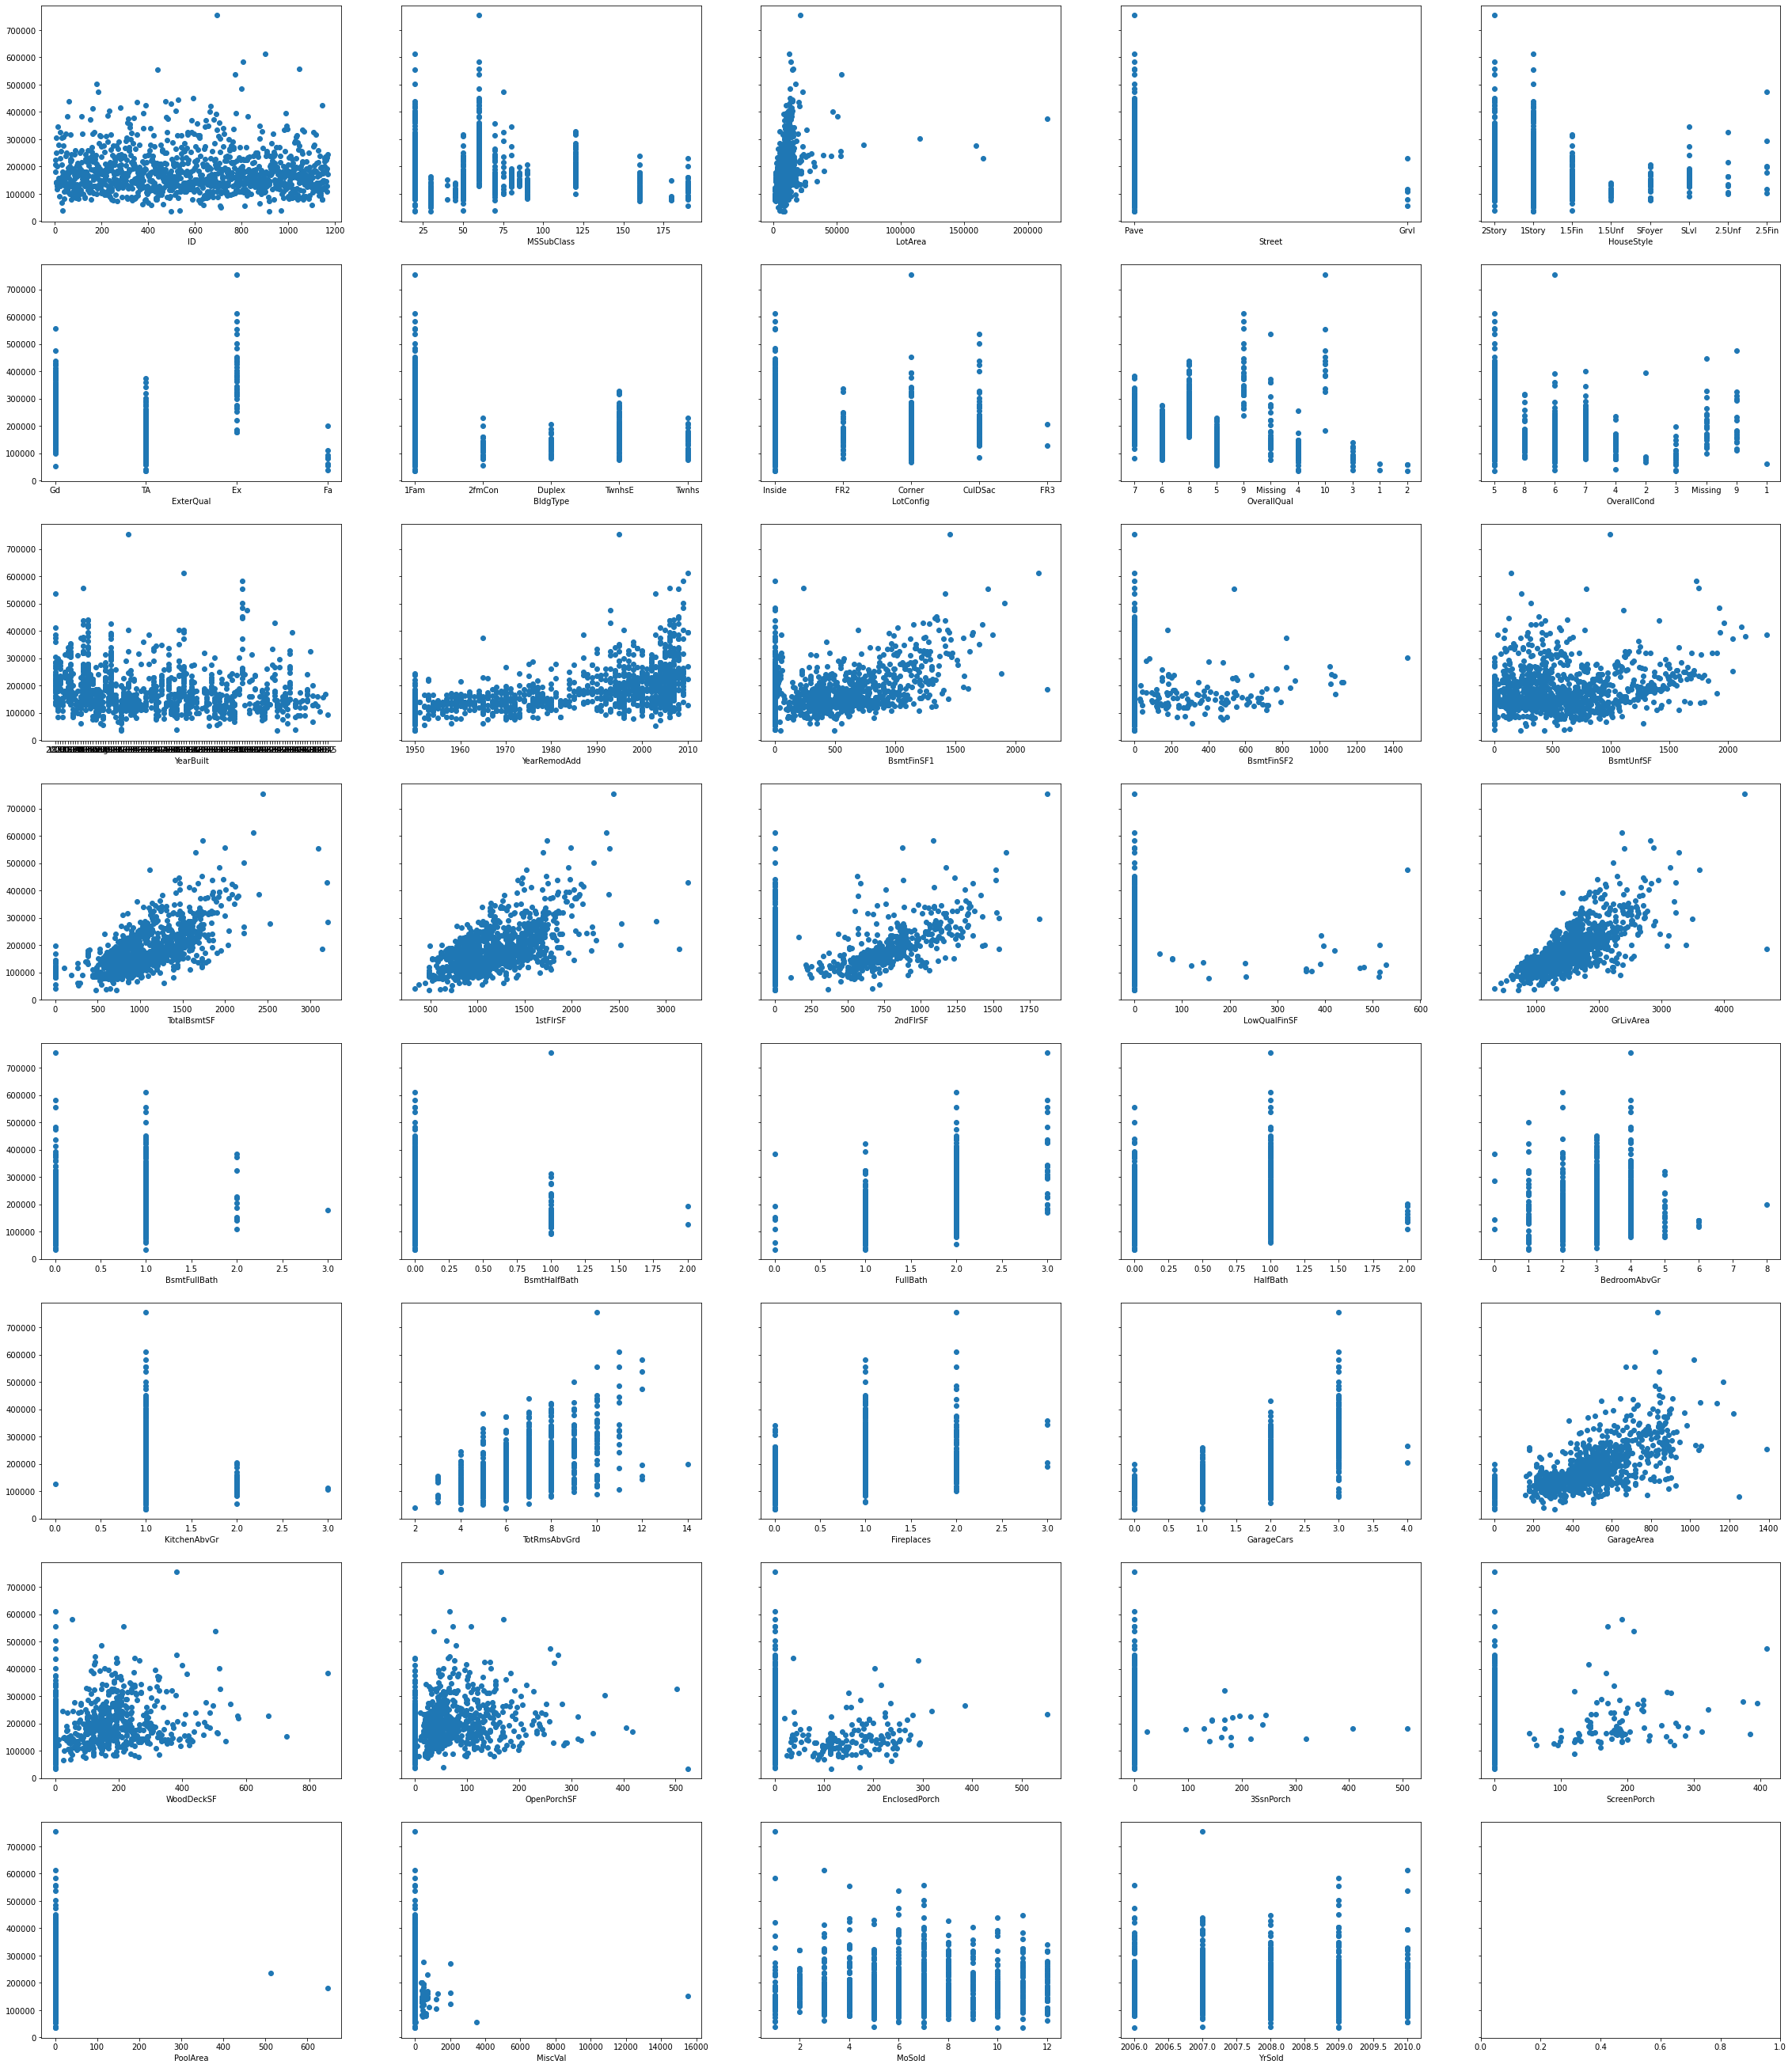

In [693]:
# Check scatter
plot_custom_subplot(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'], plot_type='scatter', save_fig=True, fig_name='raw_train_data_')
# Observation: Pool area, Misc Val, Month sold candidates don't show an obvious correlation to sale price

## 1.4 Inspect skew

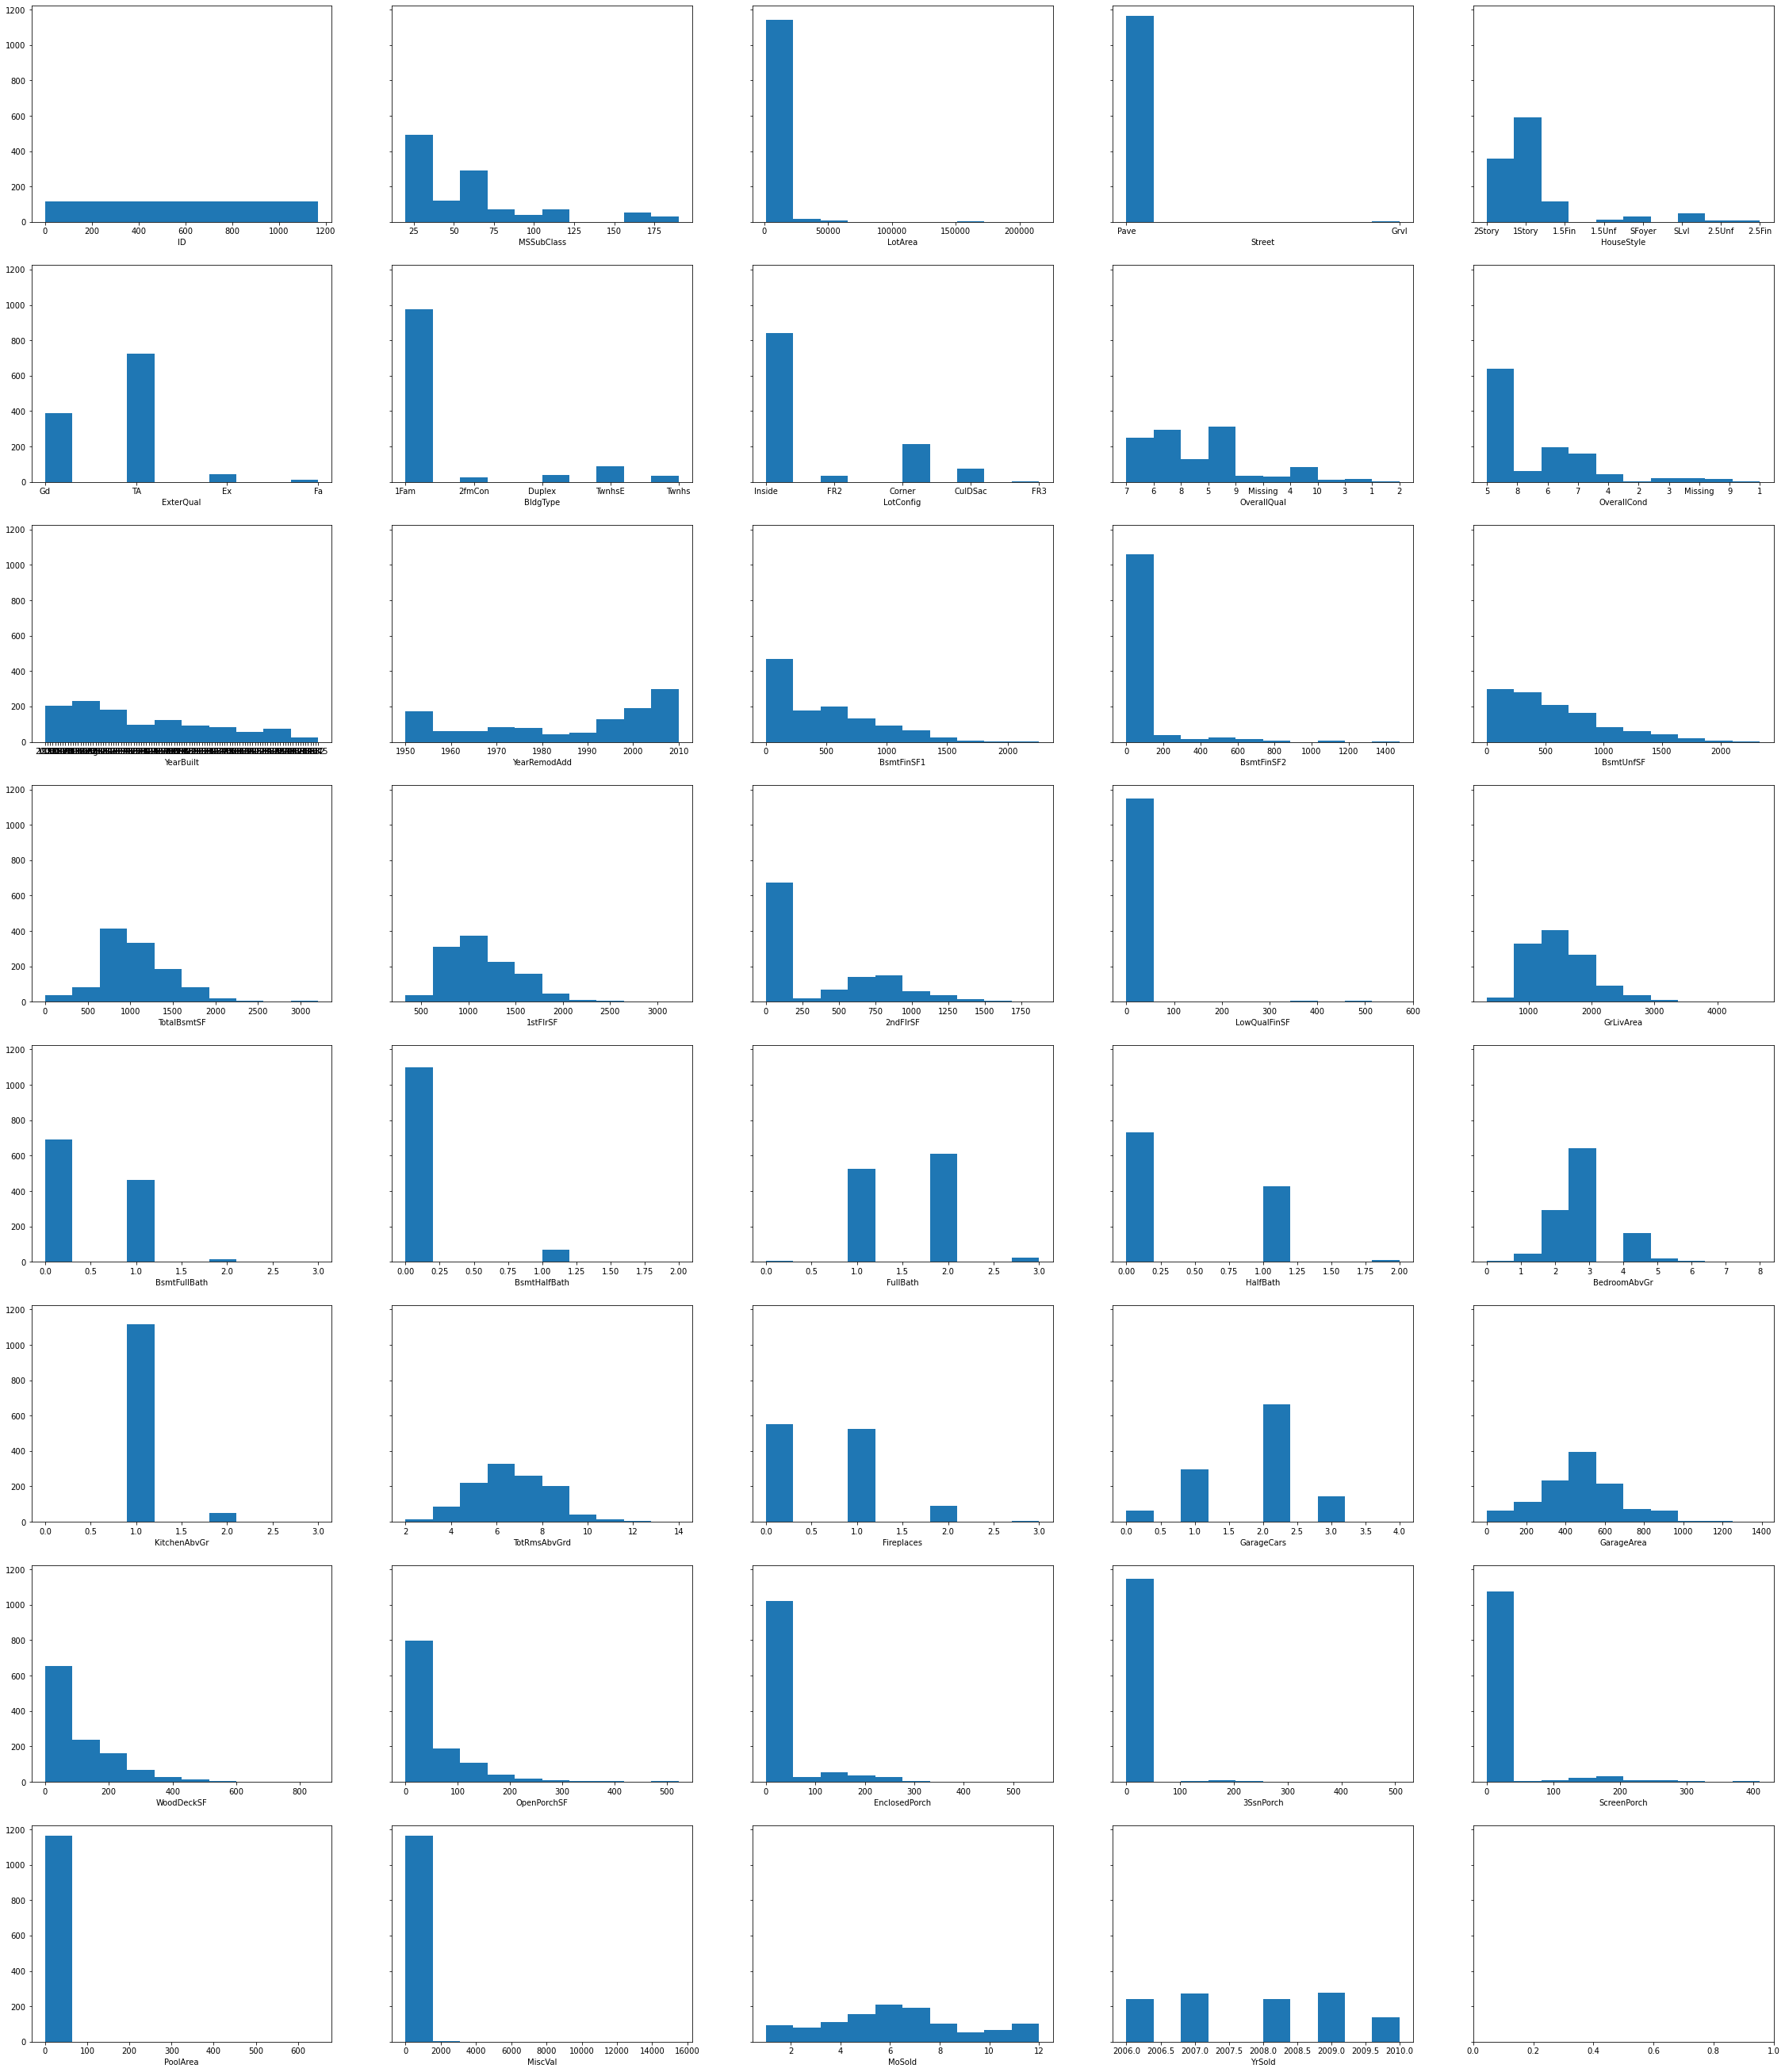

In [694]:
# Check feature distribution
plot_custom_subplot(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'], plot_type='histogram', save_fig=True, fig_name='raw_train_data_')
# Observation: ID should be dropped because it has no useful information. Some skew exists in the features

1.7487112596222822


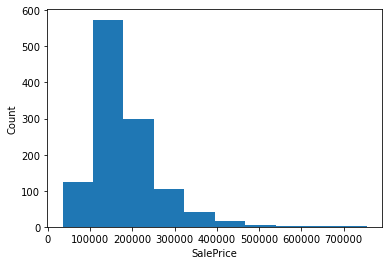

In [695]:
# Check sale price distribution
plt.hist(train_data['SalePrice'])
plt.xlabel('SalePrice')
plt.ylabel('Count')
plt.savefig('raw_train_data_SalePrice_histogram.png', format='png')

print(train_data['SalePrice'].skew())
# Observation: strong right skew in the sale price, which should get corrected.

In [647]:
# Evaluate skew of each feature
num_feats = train_data.dtypes[train_data.dtypes!='object'].index
skew_feats = train_data[num_feats].skew().sort_values(ascending=False)
print(skew_feats)
# Observation: MiscVal and PoolArea have highest skew. Again, candidate to be dropped.

MiscVal          27.966380
PoolArea         24.623340
LotArea          12.240663
3SsnPorch        10.208476
LowQualFinSF      8.684560
KitchenAbvGr      4.596279
BsmtFinSF2        4.313216
BsmtHalfBath      3.948249
ScreenPorch       3.936139
EnclosedPorch     3.168149
OpenPorchSF       2.292215
SalePrice         1.748711
WoodDeckSF        1.484201
MSSubClass        1.410259
GrLivArea         1.078755
1stFlrSF          0.963637
BsmtUnfSF         0.951956
2ndFlrSF          0.815896
BsmtFinSF1        0.789096
TotRmsAbvGrd      0.672153
HalfBath          0.659175
Fireplaces        0.645413
BsmtFullBath      0.642196
TotalBsmtSF       0.563757
BedroomAbvGr      0.290898
MoSold            0.199846
GarageArea        0.097302
YrSold            0.095714
FullBath          0.048092
ID                0.000000
GarageCars       -0.389608
YearRemodAdd     -0.520319
dtype: float64


# 2.Process the data

## 2.1 Impute or drop 'Missing' data

In [648]:
def get_cols_with_missing(df, value="Missing") -> list:
    """Return a list of column names that contain the value.

    Args:
        df (pd dataframe): the features
        value (any, Missing): Default='Missing'

    Returns:
        unique_cols: a list of the columns that contain 'Missing'
    """

    listCols = list()

    # Get bool dataframe with True at locations where the value is found
    result = df.isin([value])
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listCols.append(col)

    unique_cols = np.unique(listCols)
    return unique_cols


In [649]:
# Find which columns contain 'Missing' data
train_cols_with_missing = get_cols_with_missing(train_data, "Missing")
print(f'train_data has these columns that contain \'Missing\': {train_cols_with_missing}')

test_cols_with_missing = get_cols_with_missing(test_data, "Missing")
print(f'test_data has these columns that contain \'Missing\': {test_cols_with_missing}')


train_data has these columns that contain 'Missing': ['OverallCond' 'OverallQual' 'YearBuilt']
test_data has these columns that contain 'Missing': ['OverallCond' 'OverallQual' 'YearBuilt']


In [650]:
def replace_missing_with_mean(df, cols_with_missing:list):
    """Replace the fields in the dataframe with the mean of its column.

    Args:
        df (pd dataframe): features
        cols_with_missing (list): list of the columns in the features that contain 'Missing'

    Returns:
        df_copy (pdf dataframe): A modified copy of the dataframe
    """

    df_copy = df.copy()
    df_copy.replace(to_replace="Missing", value=np.nan, inplace=True)

    for col in cols_with_missing:
        df_copy[col] = df_copy[col].astype('float') # because NaN is a float and mean() requires same data type
        df_copy[col].fillna(value=df_copy[col].mean(), inplace=True) 
    
    return df_copy

In [651]:
def get_rows_with_missing_data(df_object, cols_with_missing:list):
    """Find row if it contains 'Missing' in any of the columns in cols_with_missing."""

    rows_with_missing = []
    for index, row in df_object.iterrows():
        # If the row contains at least one 'Missing' then append to the list
        num_missing = 0
        for col in cols_with_missing:
            if row[col] == 'Missing':
                num_missing += 1
        if num_missing > 0:
            rows_with_missing.append(row)

    return rows_with_missing

In [652]:
# Evaluate how many rows have 'Missing' data
train_rows_with_missing = get_rows_with_missing_data(train_data, train_cols_with_missing)
test_rows_with_missing = get_rows_with_missing_data(test_data, test_cols_with_missing)

print(f'Train.csv has {len(train_rows_with_missing)} rows with \'Missing\' data out of {len(train_data)}.')
print(f'Test.csv has {len(test_rows_with_missing)} rows with \'Missing\' data out of {len(test_data)}.')

Train.csv has 66 rows with 'Missing' data out of 1168.
Test.csv has 15 rows with 'Missing' data out of 292.


In [653]:
def drop_rows(df):
    """Drops rows if the columns OverallCond, OverallQual of YearBuilt contain 'Missing'."""
    df_copy = df[(df['OverallCond'] != 'Missing') & (df['OverallQual'] != 'Missing') & (df['YearBuilt'] !='Missing')] 
    return df_copy

In [654]:
def fix_missing_data(df, missing_data_treatment='mean'):
    """Fixes the 'Missing' data in the dataset.

    Args:
        df (pd dataframe): the features
        missing_data_treatment (str, optional): 'mean' or 'drop'. Defaults to 'mean'.

    Returns:
        df_fixed: a copy of the data frame with the 'Missing' data treatment applied.
    """
    if missing_data_treatment =='mean': # impute
        cols_with_missing = get_cols_with_missing(df, "Missing")
        df_fixed = replace_missing_with_mean(df, cols_with_missing)
    if missing_data_treatment =='drop':
        df_fixed = drop_rows(df)
    return df_fixed

In [655]:
# Apply the fix for the 'Missing data'
train_imputed = fix_missing_data(train_data, 'mean')
train_dropped = fix_missing_data(train_data, 'drop')

test_imputed = fix_missing_data(test_data, 'mean')
test_dropped = fix_missing_data(test_data, 'drop')

In [656]:
# Sanity check the new dataframes after the fix is applied
print(f'train_imputed has {len(train_imputed)} rows.')
print(f'train_dropped has {len(train_dropped)} rows.')
print(f'test_imputed has {len(test_imputed)} rows.')
print(f'test_dropped has {len(test_dropped)} rows.')

train_imputed has 1168 rows.
train_dropped has 1102 rows.
test_imputed has 292 rows.
test_dropped has 277 rows.


## 2.2 Change dtypes to numerical


In [657]:
# Linear regression only supports numericals and these columns are string datatypes so we need to change them.
def change_dtype(df):
    df = df.astype({'OverallCond': int})
    df = df.astype({'OverallQual': int})
    df = df.astype({'YearBuilt': int})
    return df

In [658]:
# Apply the data type change
train_imputed = change_dtype(train_imputed)
train_dropped = change_dtype(train_dropped)

test_imputed = change_dtype(test_imputed)
test_dropped = change_dtype(test_dropped)

## 2.3 Change year data to years since

In [659]:
def change_year_data(train_data, test_data, current_year=2022):
    """Change the year data (in place) from absolute to difference vs. current_year to improve regression modelling.

    Args:
        train_data (pd dataframe): training features
        test_data (pd dataframe): test data
        current_year (int, optional): Defaults to 2022.
    """
    train_data['YearRemodAdd'] = current_year - train_data['YearRemodAdd']
    test_data['YearRemodAdd'] = current_year - test_data['YearRemodAdd']

    train_data['YearBuilt'] = current_year - train_data['YearBuilt']
    test_data['YearBuilt'] = current_year - test_data['YearBuilt']

    train_data['YrSold'] = current_year - train_data['YrSold']
    test_data['YrSold'] = current_year - test_data['YrSold']

    # Rename columns
    # train_data.rename({'YearRemodAdd': 'YearsSinceRemodAdd'}, axis=1, inplace=True)
    # train_data.rename({'YearBuilt': 'YearsSinceBuilt'}, axis=1, inplace=True)
    # train_data.rename({'YrSold': 'YearsSinceSold'}, axis=1, inplace=True)

    # test_data.rename({'YearRemodAdd': 'YearsSinceRemodAdd'}, axis=1, inplace=True)
    # test_data.rename({'YearBuilt': 'YearsSinceBuilt'}, axis=1, inplace=True)
    # test_data.rename({'YrSold': 'YearsSinceSold'}, axis=1, inplace=True)


In [660]:
# Apply the change to the columns with Year data
change_year_data(train_dropped, test_dropped)
change_year_data(train_imputed, test_imputed)

## 2.4 Fix skew training data

In [661]:
from scipy.stats import boxcox

def unskew(df):
    """Unskew the data via scipy's boxcox implementation to evaluate a normal distribution.

    Args:
        df (pd dataframe): features

    Returns:
        df_copy (pd dataframe): copy of the modified dataframe
        lmbda_map (dict): the lmbda value for each column in the dataframe
    """
    df_copy = df.copy()
    lmbda_map = {} # store lambda values to later apply on the corresponding test set
    for col_name, skew_value in skew_feats.iteritems():
        df_copy[col_name] += 1 # boxcox requires strictly > 0. Add 1 like boxcox1p.
        df_copy[col_name], lmbda_value = boxcox(df_copy[col_name], lmbda=None)
        lmbda_map.update({col_name: lmbda_value})
    return df_copy, lmbda_map


In [662]:
# Apply the fix for skewed training data
train_imputed_unskewed, train_imputed_unskewed_lmbda_map  = unskew(train_imputed)
train_dropped_unskewed, train_dropped_unskewed_lmbda_map = unskew(train_dropped)

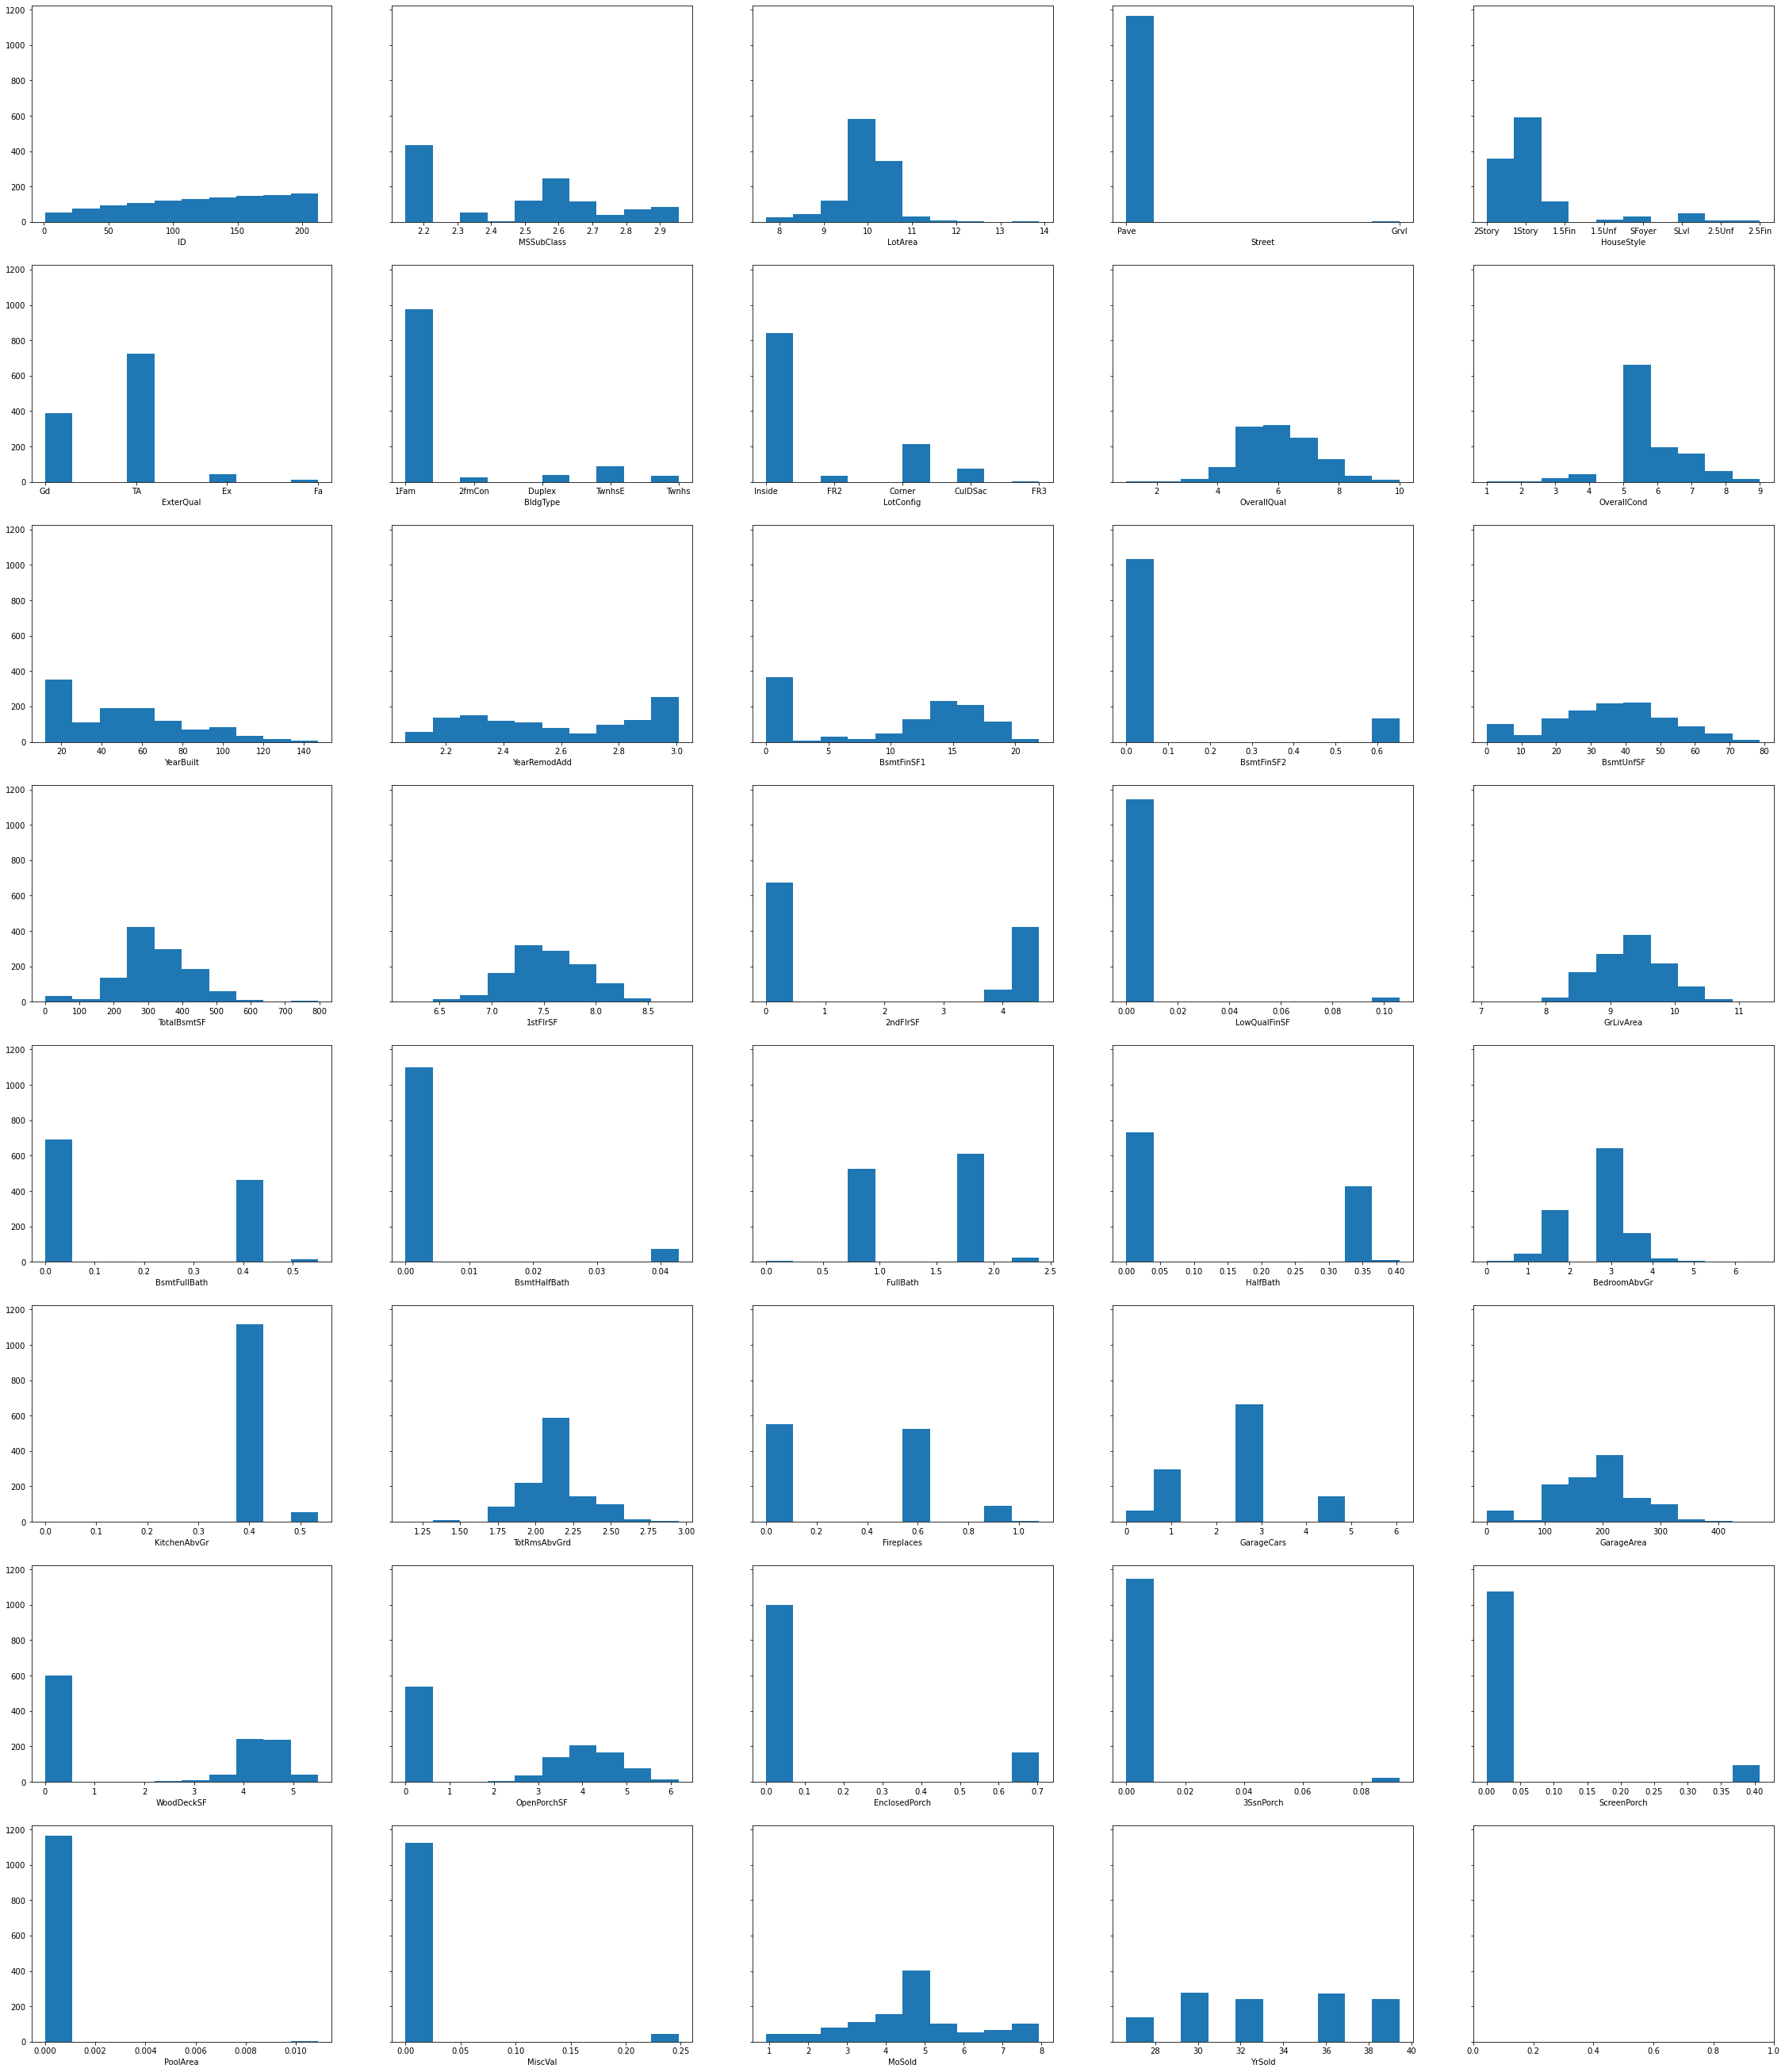

In [663]:
# Examine the effect of applying boxcox on the imputed dataset
plot_custom_subplot(train_imputed_unskewed.drop('SalePrice', axis = 1), train_imputed_unskewed['SalePrice'], plot_type='histogram')
# Observation: Noticeable improvement in LotArea and the most but not all the area features (SF= square feet). Certaintly not all the features have normal distributions after boxcox.

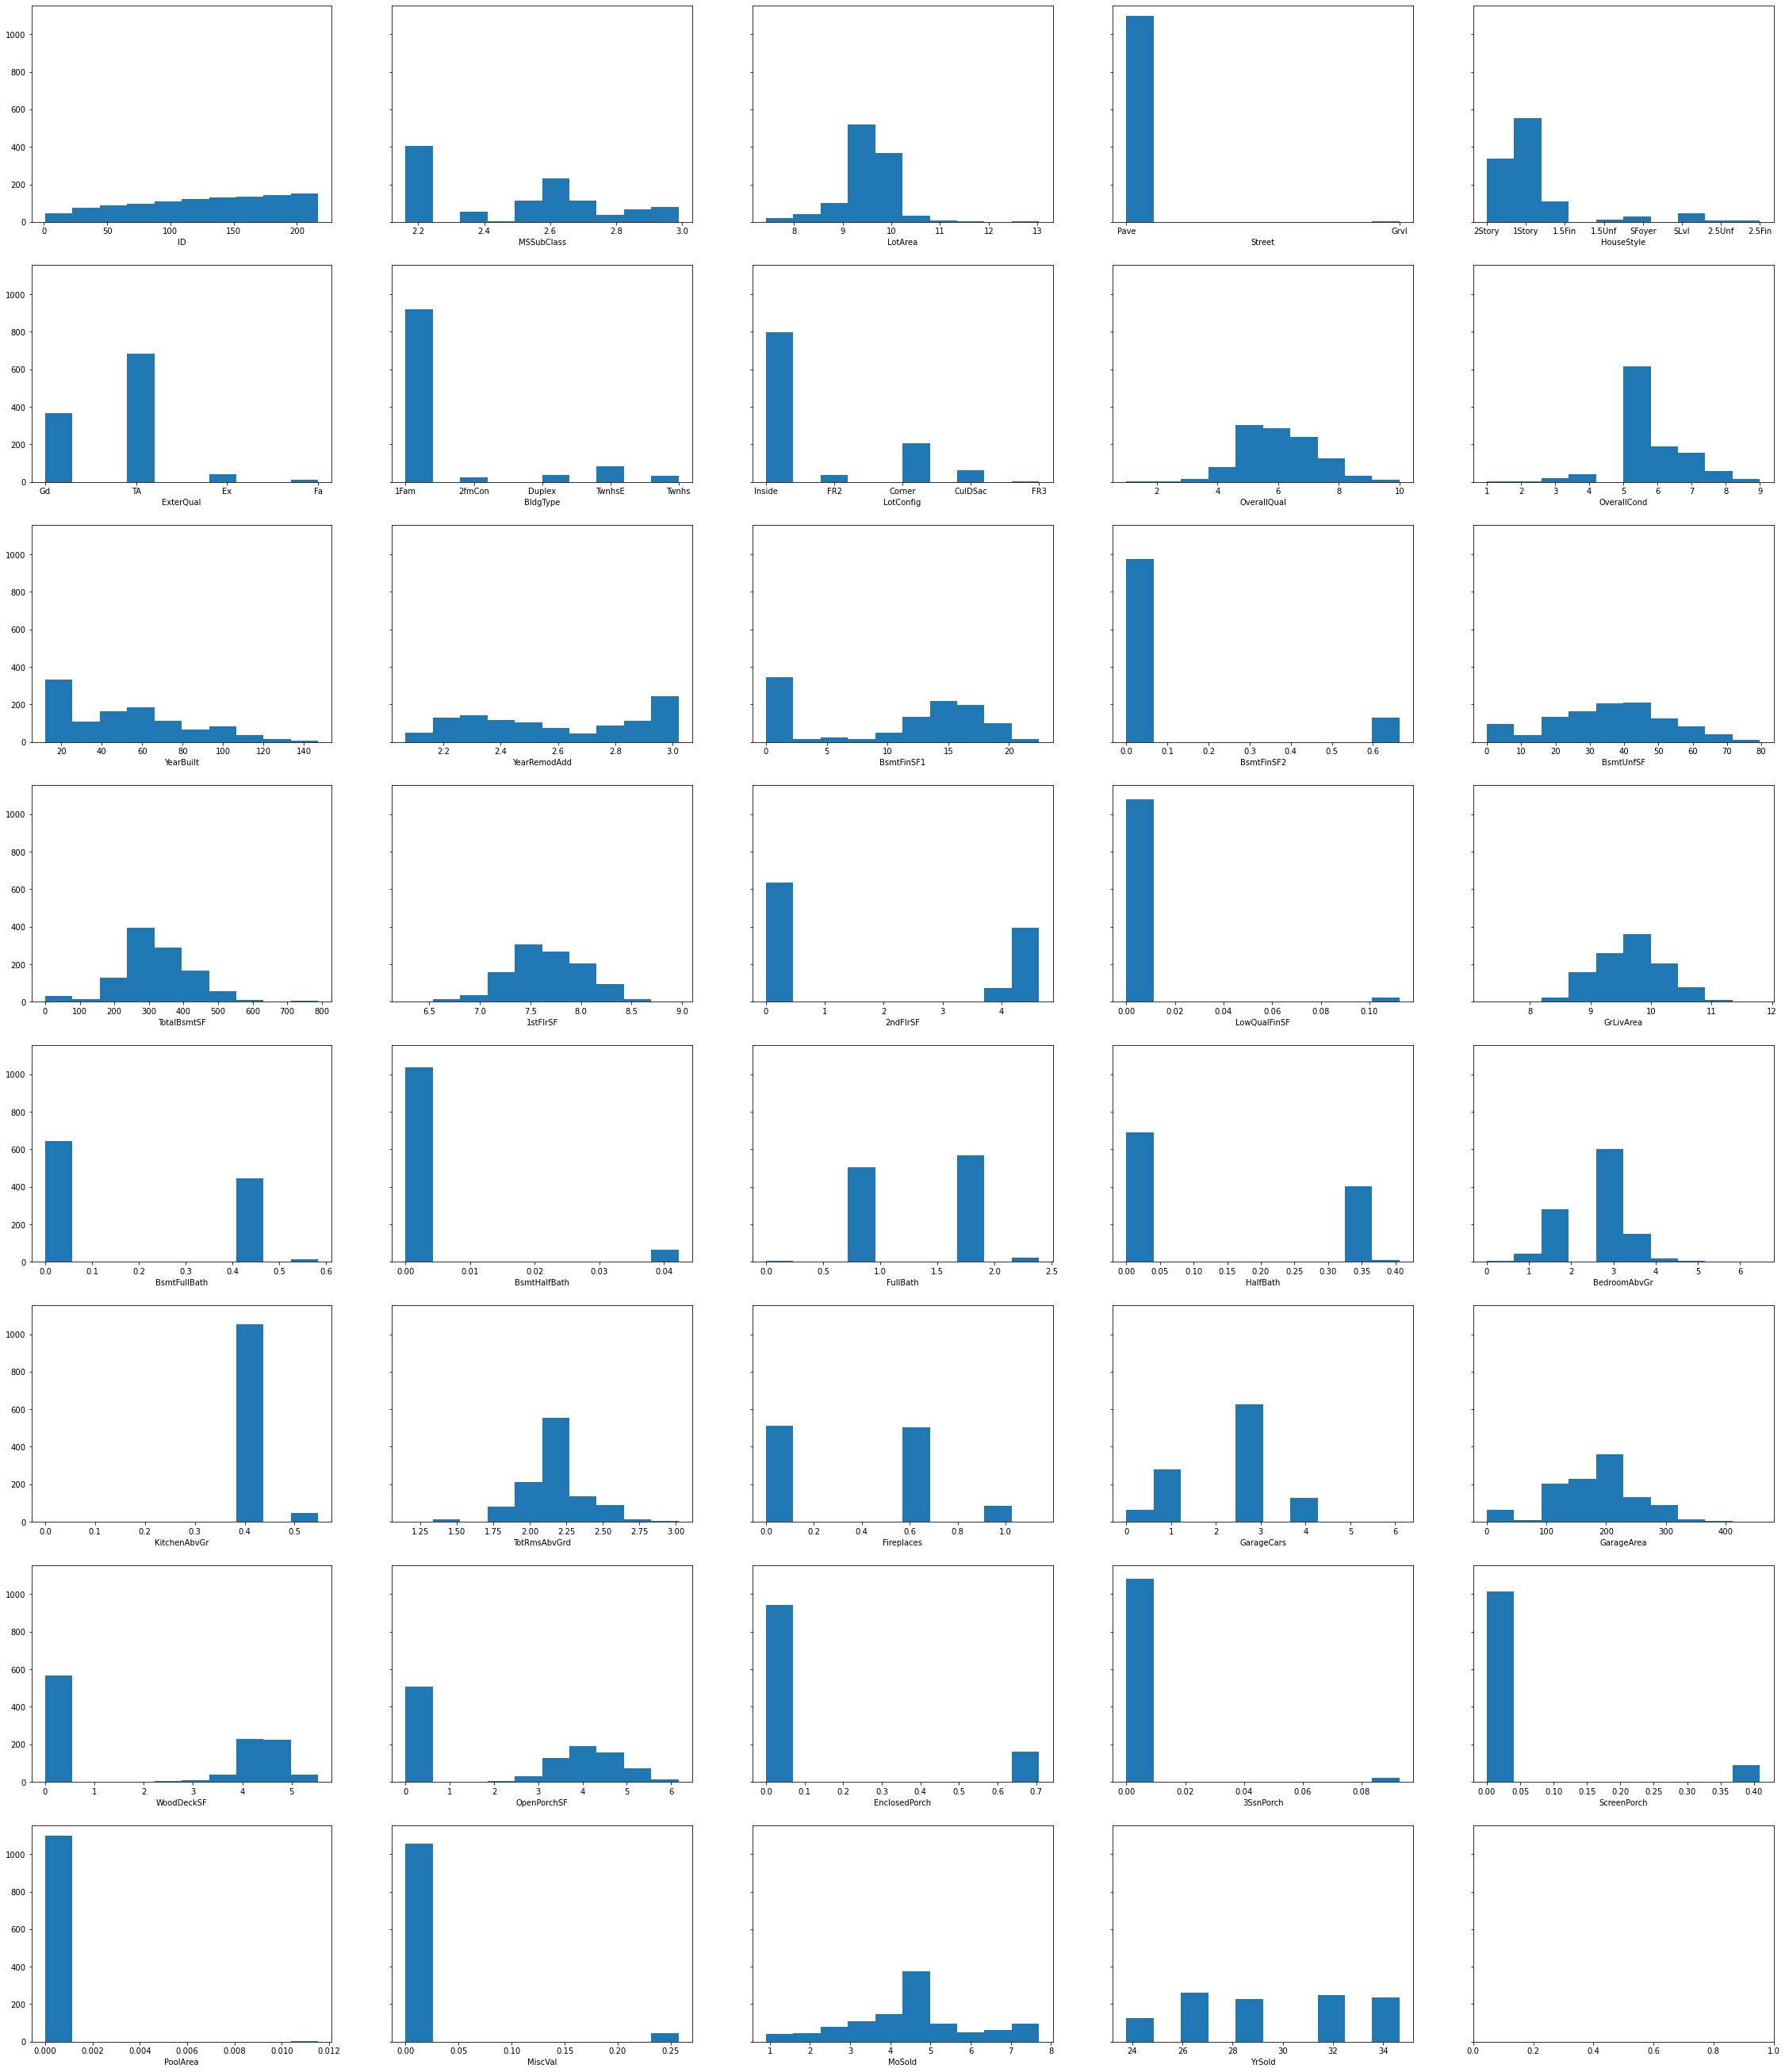

In [664]:
# Examine the effect of applying boxcox on the dropped dataset
plot_custom_subplot(train_dropped_unskewed.drop('SalePrice', axis = 1), train_dropped_unskewed['SalePrice'], plot_type='histogram')
# Observation: no obvious difference to the distributions vs. imputed data. Probably because percentage of rows dropped vs. original total is small.

(array([  5.,   7.,  30., 125., 341., 347., 206.,  81.,  21.,   5.]),
 array([8.11006086, 8.27713657, 8.44421228, 8.61128799, 8.7783637 ,
        8.94543941, 9.11251512, 9.27959083, 9.44666654, 9.61374225,
        9.78081796]),
 <BarContainer object of 10 artists>)

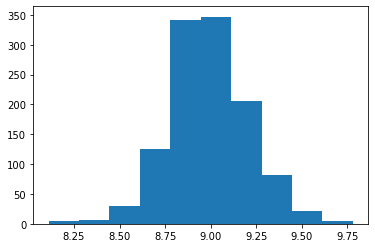

In [665]:
# Check unskewed imputed sale price
plt.hist(train_imputed_unskewed['SalePrice'])


(array([  5.,   8.,  28., 125., 330., 324., 186.,  75.,  16.,   5.]),
 array([ 8.57364489,  8.76543424,  8.95722359,  9.14901294,  9.34080229,
         9.53259164,  9.72438099,  9.91617034, 10.10795969, 10.29974903,
        10.49153838]),
 <BarContainer object of 10 artists>)

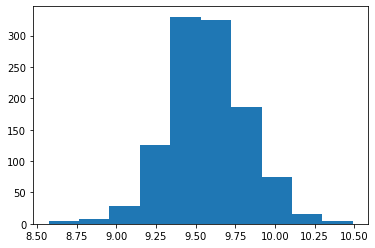

In [666]:
# Check unskewed dropped sale price
plt.hist(train_dropped_unskewed['SalePrice'])

## 2.5 Fix skew test data

In [667]:
def apply_lmbda_to_test(df, lmbda_dict):
    df_copy = df.copy()
    for key, value in lmbda_dict.items():
        df_copy[key] += 1 # boxcox requires strictly > 0. Add 1 like boxcox1p
        df_copy[key] = boxcox(df_copy[key], lmbda=value)
    return df_copy

In [668]:
# Unskew the test data
test_imputed_unskewed  = apply_lmbda_to_test(test_imputed, train_imputed_unskewed_lmbda_map)
test_dropped_unskewed = apply_lmbda_to_test(test_dropped, train_dropped_unskewed_lmbda_map )

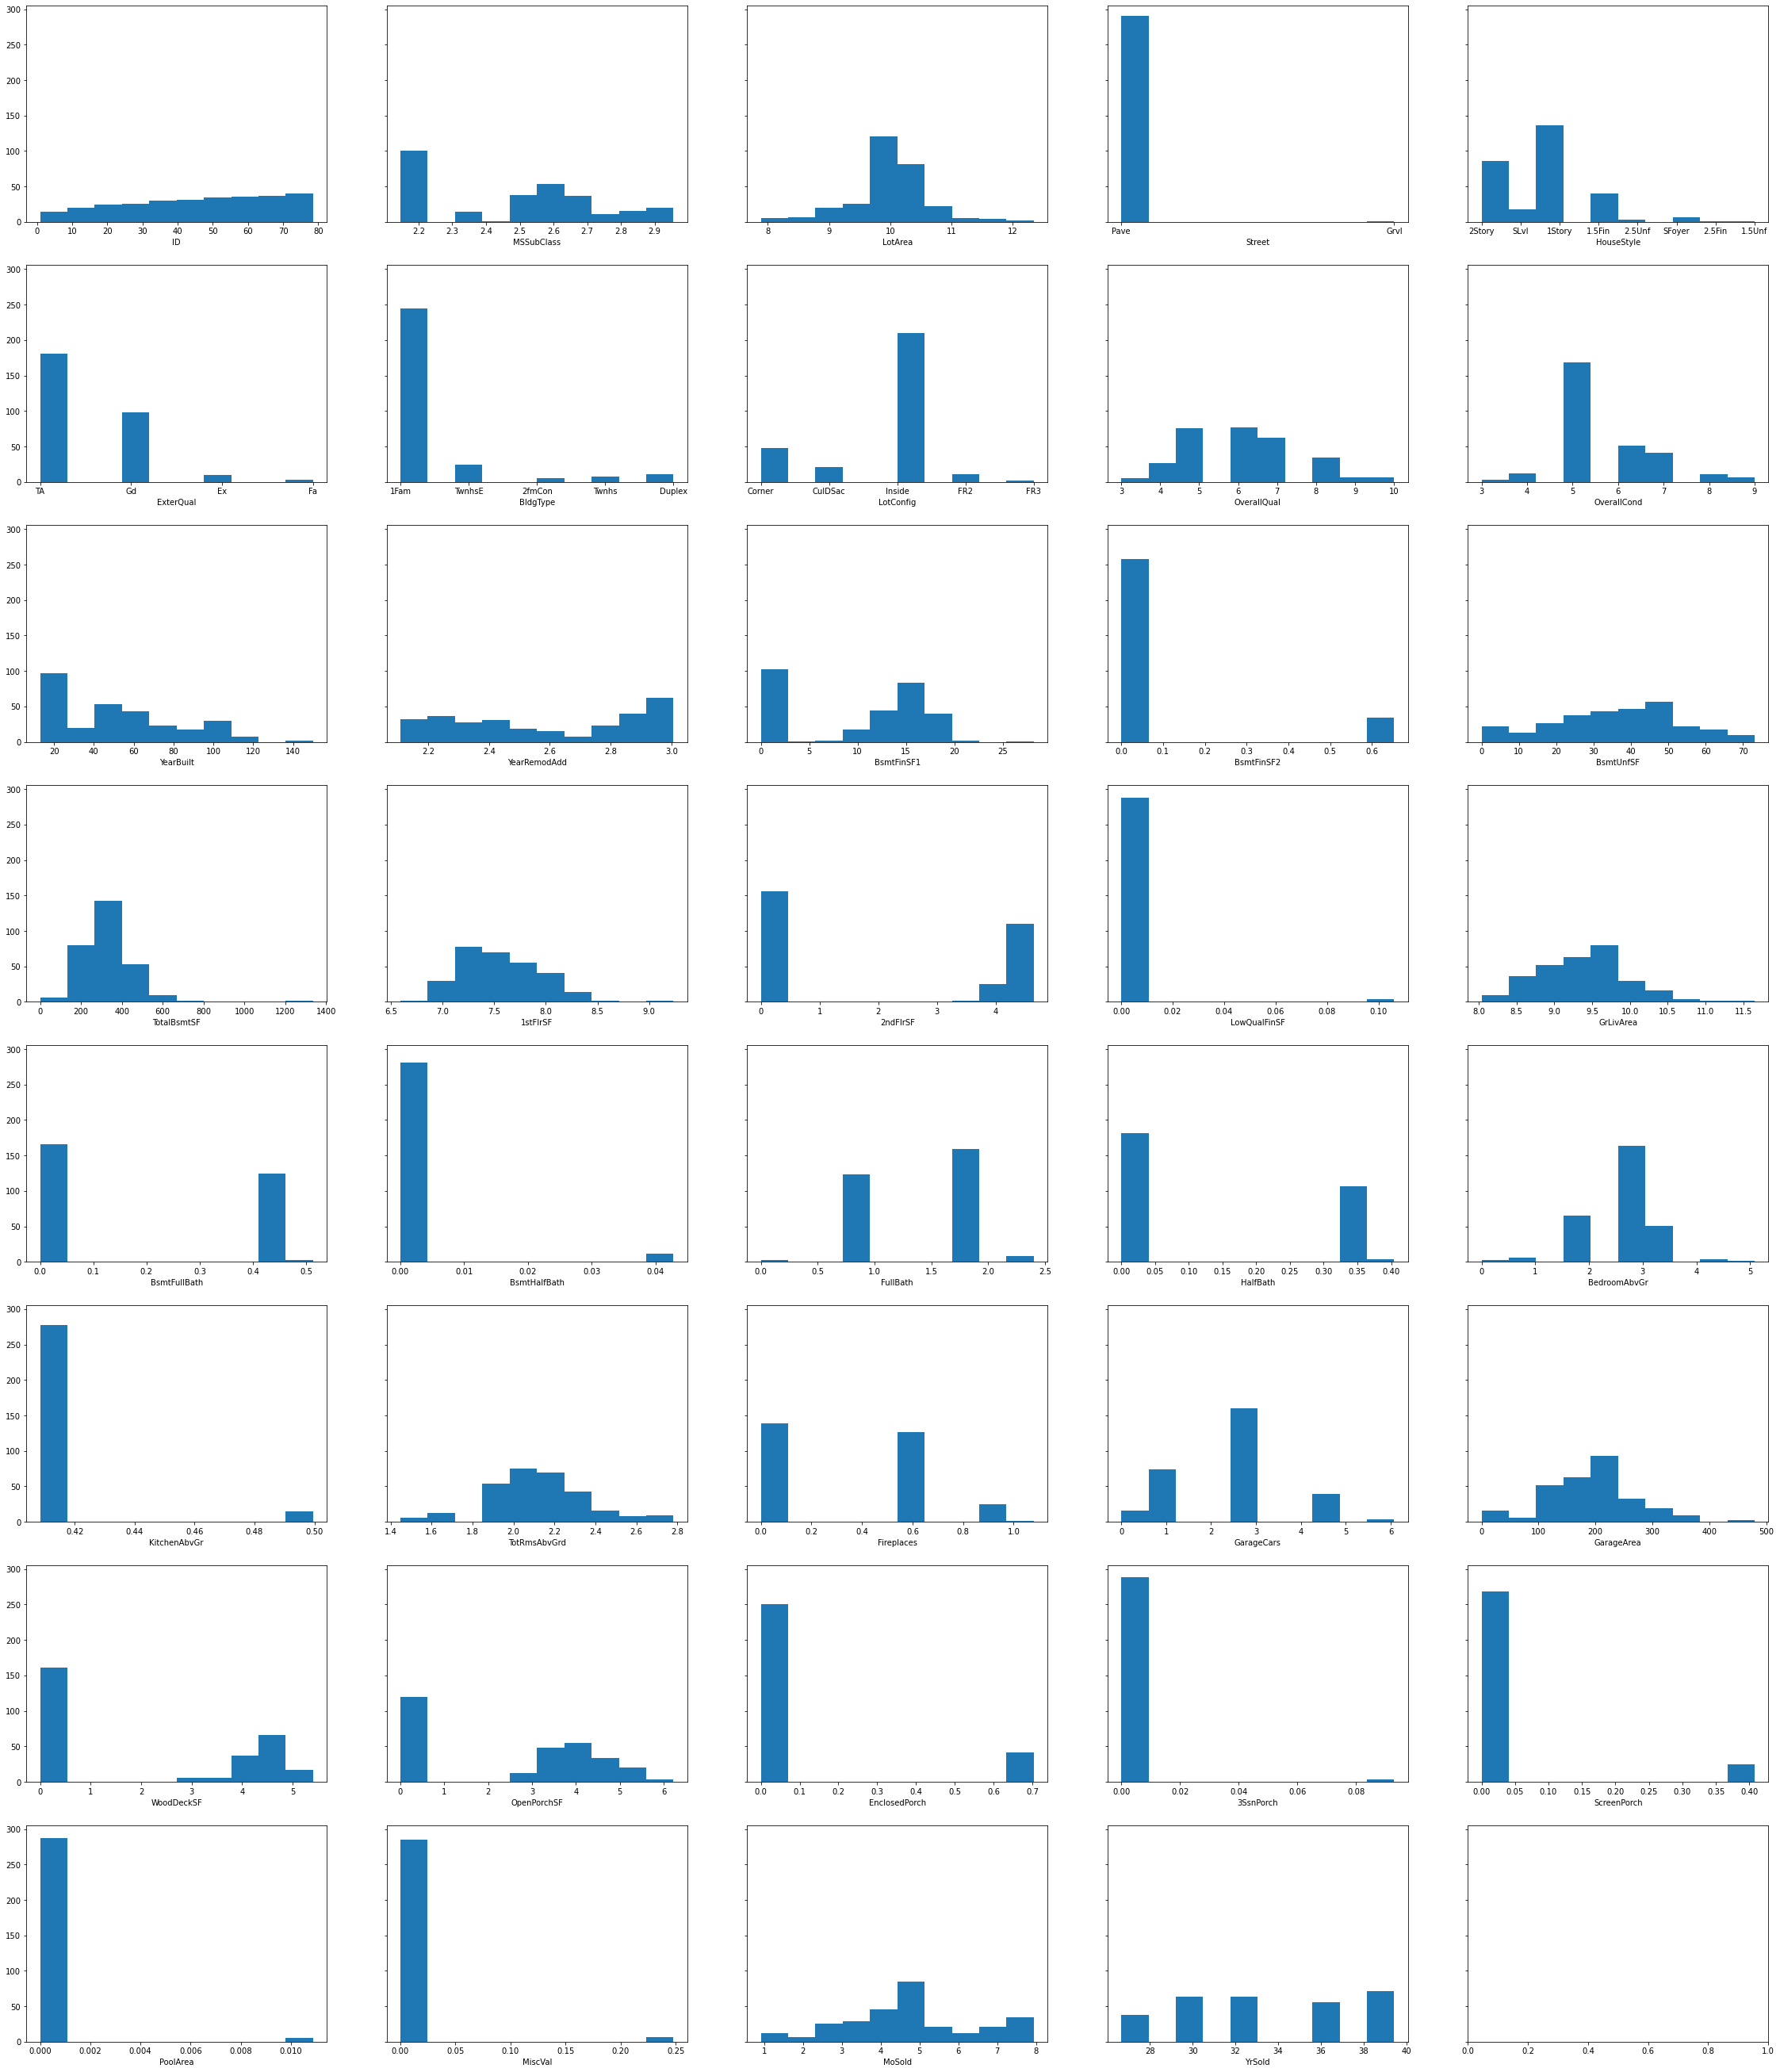

In [669]:
# Check the unskewed imputed test data
plot_custom_subplot(test_imputed_unskewed.drop('SalePrice', axis = 1), test_imputed_unskewed['SalePrice'], plot_type='histogram')

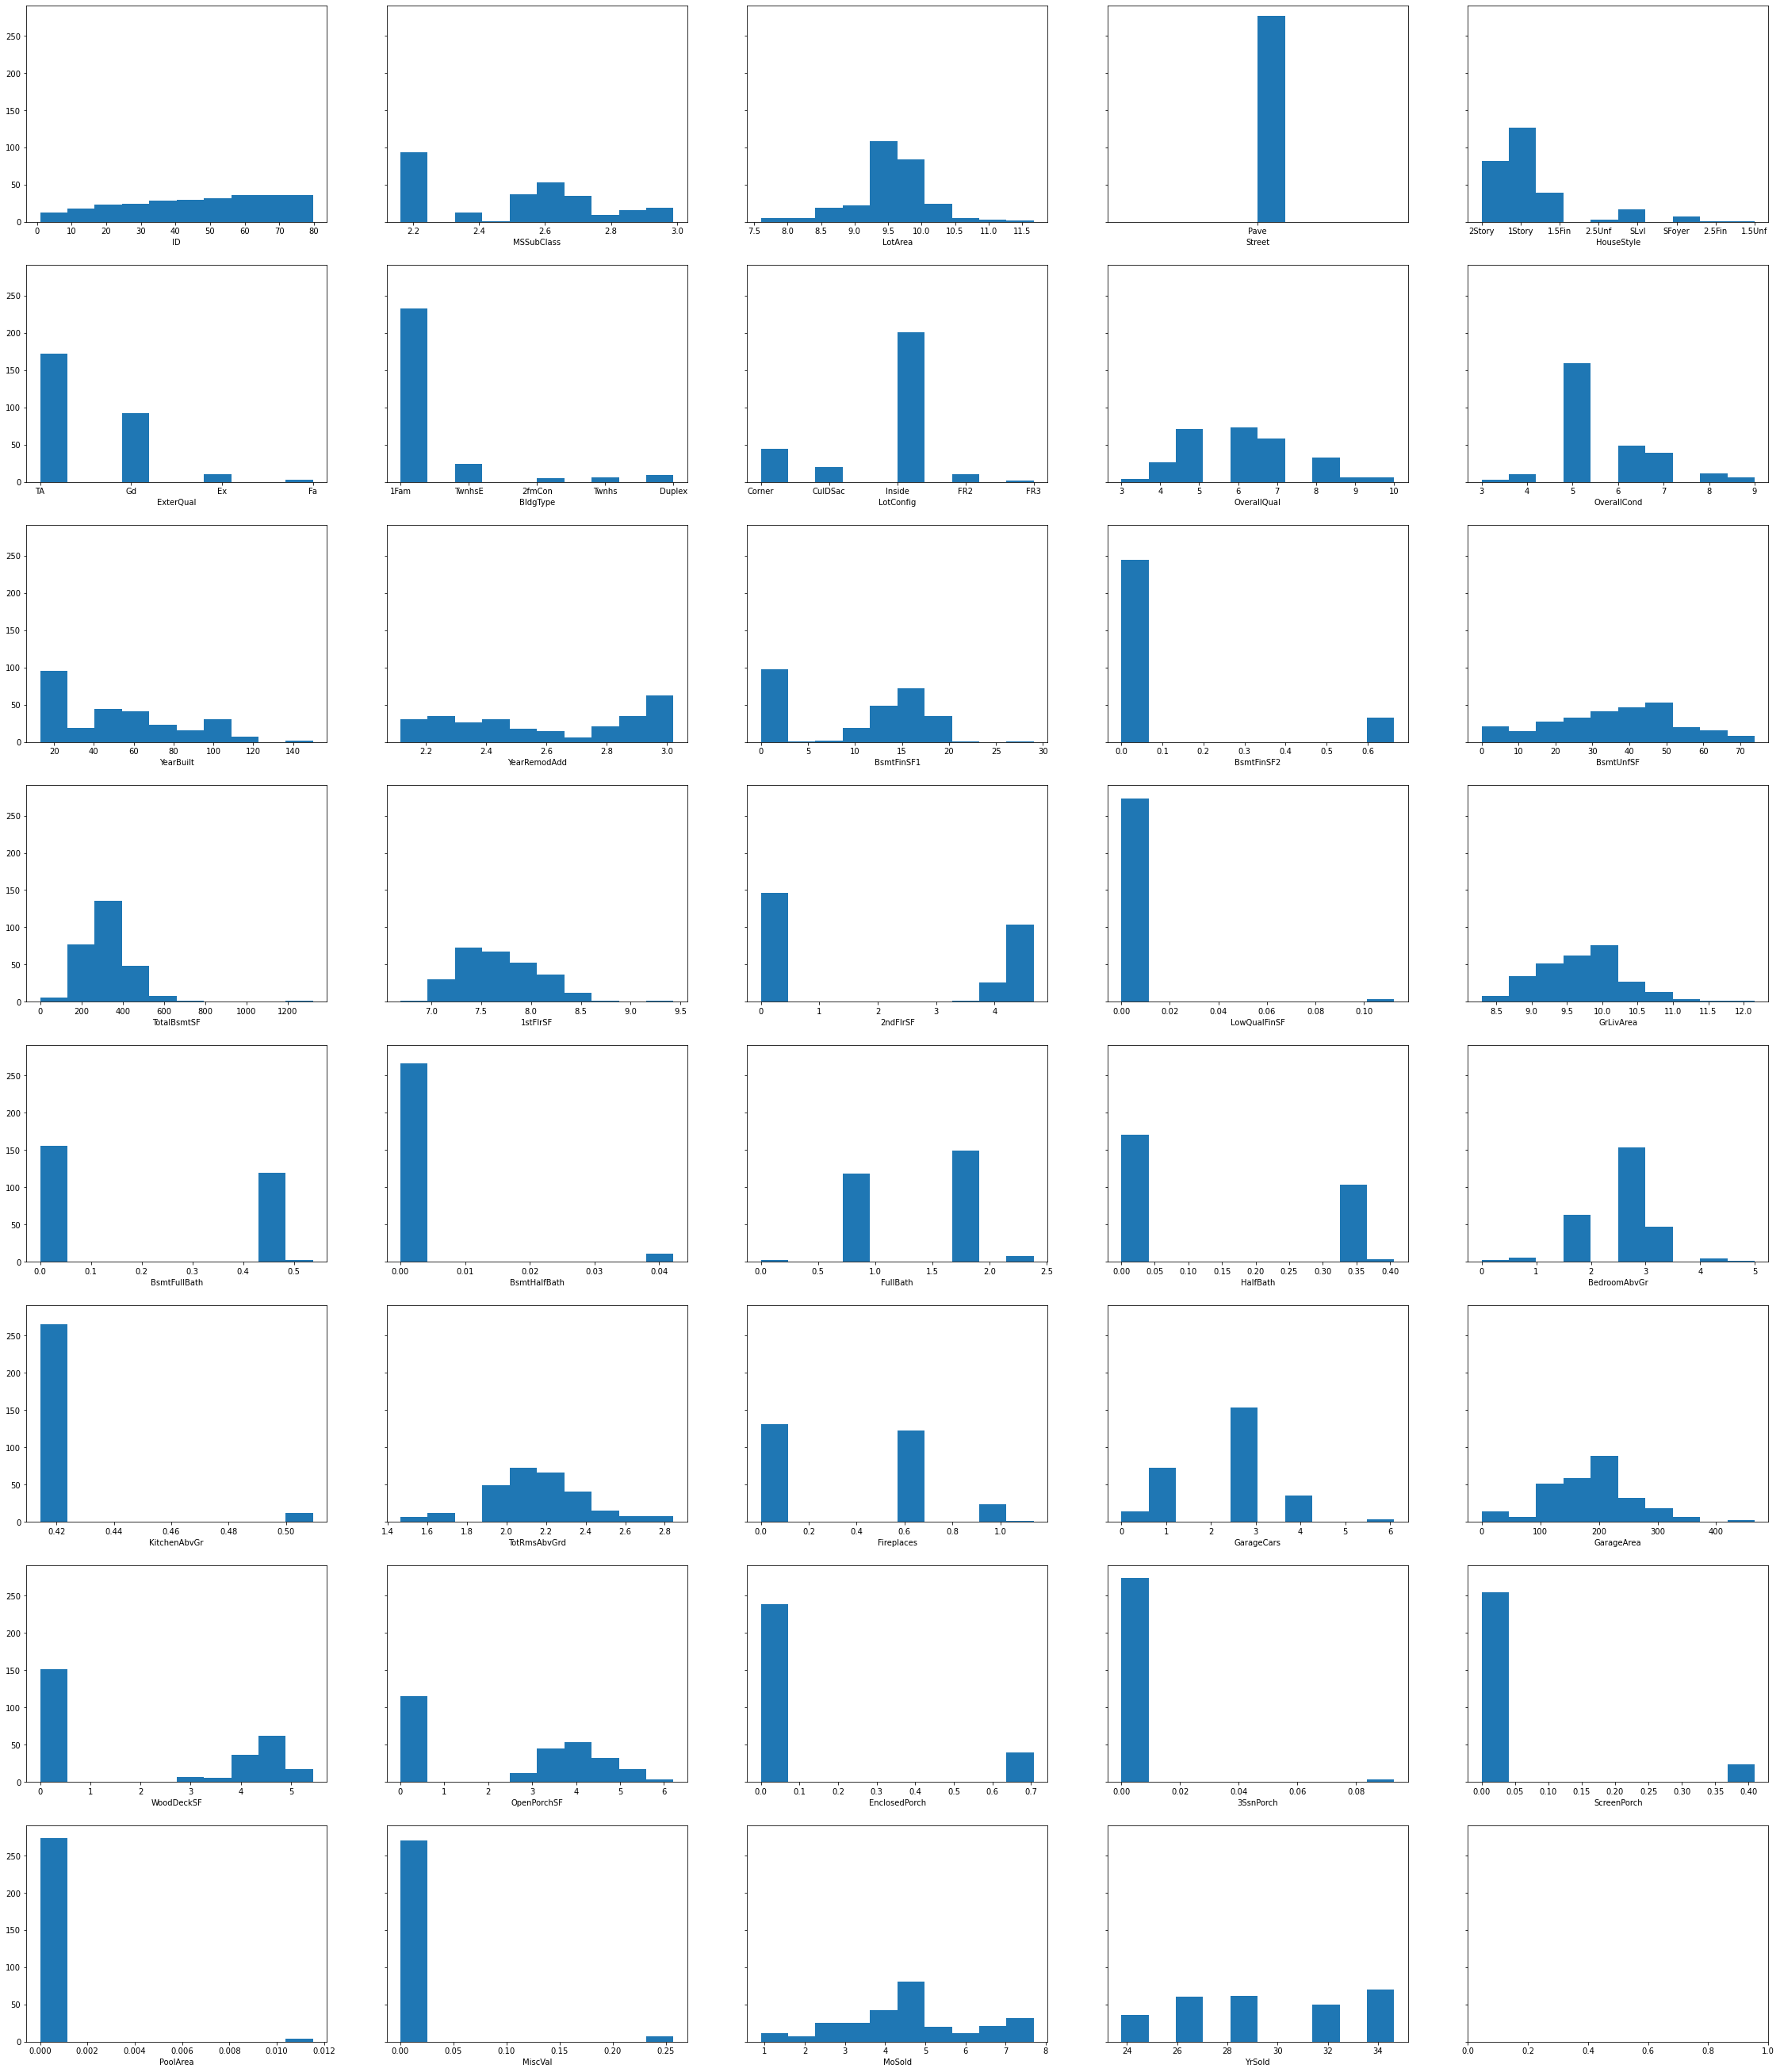

In [670]:
# Check the unskewed dropped test data
plot_custom_subplot(test_dropped_unskewed.drop('SalePrice', axis = 1), test_dropped_unskewed['SalePrice'], plot_type='histogram')

(array([ 4.,  7., 23., 83., 76., 51., 33., 11.,  2.,  2.]),
 array([8.34731509, 8.48999574, 8.63267638, 8.77535702, 8.91803767,
        9.06071831, 9.20339895, 9.34607959, 9.48876024, 9.63144088,
        9.77412152]),
 <BarContainer object of 10 artists>)

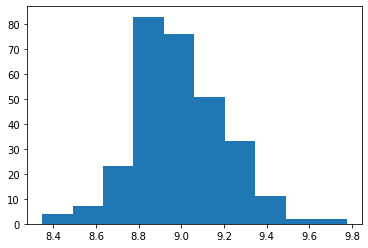

In [671]:
# Check the imputed unskewed test data 
plt.hist(test_imputed_unskewed['SalePrice'])

(array([ 4.,  6., 23., 79., 75., 46., 30., 10.,  2.,  2.]),
 array([ 8.8419469 ,  9.00612334,  9.17029979,  9.33447623,  9.49865267,
         9.66282911,  9.82700556,  9.991182  , 10.15535844, 10.31953488,
        10.48371133]),
 <BarContainer object of 10 artists>)

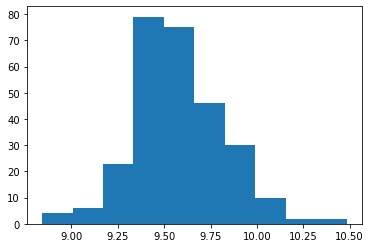

In [672]:
# Check the dropped unskewed test data
plt.hist(test_dropped_unskewed['SalePrice'])

## 2.5 Encode categoricals in training data

In [673]:
def get_categoricals(df) -> list:
    """Find the columns with 'object' datatypes in df

    Args:
        df (pd dataframe): features

    Returns:
        list: list of strings with column names
    """
    categoricals = []
    for col in df.columns:
        if df[col].dtypes == "object":
            categoricals.append(col)
    return categoricals

In [674]:
def one_hot_encode(df, categoricals:list):
    """Drop categoricals columns and concatenate one hot encoded columns to df.

    Args:
        df (pd dataframe): features
        categoricals (list): list of column names to be one hot encoded.

    Returns:
        df_copy (pd dataframe): modifed df after one hot encoding.
    """

    df_copy = df.copy()
    for idx, category in enumerate(categoricals):
        variables_list = df_copy[category].unique()
        print(f'Column {category} has unique categories {variables_list}')
        
        if len(variables_list) == 2:
            set_arg = True # set drop_first true because categories are binary
        else:
            set_arg = False

        dummy1 = pd.get_dummies(df_copy[category], drop_first=set_arg)
        df_copy = pd.concat([df_copy, dummy1], axis=1).drop(category, axis=1)
    
    print('\n')
    return df_copy


In [675]:
def encode_categoricals(data):

    categoricals = get_categoricals(data)
    data = one_hot_encode(data, categoricals)

    return data

In [676]:
# Apply one hot encoding
train_imputed_encoded = encode_categoricals(train_imputed)
train_dropped_encoded = encode_categoricals(train_dropped)
train_imputed_unskewed_encoded  = encode_categoricals(train_imputed_unskewed)
train_dropped_unskewed_encoded = encode_categoricals(train_dropped_unskewed)

test_imputed_encoded  = encode_categoricals(test_imputed)
test_dropped_encoded = encode_categoricals(test_dropped)
test_imputed_unskewed_encoded  = encode_categoricals(test_imputed_unskewed)
test_dropped_unskewed_encoded = encode_categoricals(test_dropped_unskewed)


Column Street has unique categories ['Pave' 'Grvl']
Column HouseStyle has unique categories ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
Column ExterQual has unique categories ['Gd' 'TA' 'Ex' 'Fa']
Column BldgType has unique categories ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
Column LotConfig has unique categories ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']


Column Street has unique categories ['Pave' 'Grvl']
Column HouseStyle has unique categories ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
Column ExterQual has unique categories ['Gd' 'TA' 'Ex' 'Fa']
Column BldgType has unique categories ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
Column LotConfig has unique categories ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']


Column Street has unique categories ['Pave' 'Grvl']
Column HouseStyle has unique categories ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
Column ExterQual has unique categories ['Gd' 'TA' 'Ex' '

## 2.6 Split train, test

In [677]:
def split(df):
    X = df.drop(['SalePrice'], axis=1)
    y = df['SalePrice']
    return X, y

# 3.Linear Regression

## 3.1 Setup regression loops

In [678]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import math

def run_lin_regression(X_train, y_train, X_test, y_test):
    """Run multiple linear regression models and compare Root Mean Square Error and coefficient of determination.

    Args:
        X_train (pd dataframe): training features (independent variables)
        y_train (pd series): training labels (dependent variable)
        X_test (pd dataframe): test features
        y_test (pd series): test labels 

    Returns:
        result (list): [predicted values, Root Mean Square Error, R2 score, model name]
    """

    # Create linear regression objects
    models = dict(
        ols=linear_model.LinearRegression(), 
        ridge=linear_model.Ridge(alpha=0.1),
        huber= linear_model.HuberRegressor(max_iter=100000),
        ransac =linear_model.RANSACRegressor(random_state=0),
        theil_sen= linear_model.TheilSenRegressor()
    )

    result = []
    for name, model in models.items():
        # Train the model using the training sets
        model.fit(X_train, y_train)

        # Make predictions using the testing set
        y_predicted = model.predict(X_test)
        
        # The mean squared error
        mse = mean_squared_error(y_test, y_predicted)
        rmse = math.sqrt(mse)
        print("Root Mean Squared Error: %.3f" % rmse)

        # The coefficient of determination
        r2 = r2_score(y_test, y_predicted)
        print("Coefficient of determination: %.3f" % r2)

        result.append((y_predicted, rmse, r2, name))
    return result

## 3.2 Setup result inspection

In [679]:
def plot_predictions(result, y_test, fig_name_info=''):
    """Create subplot of the results from the linear regression models

    Args:
        result (list): [predicted values, Root Mean Square Error, R2 score, model name]
        y_test (pd series): test labels
        data_in (str, optional): _description_. Defaults to 'no_mods'.
    """

    num_plots = len(result)
    num_rows = 1
    fig, ax_array =  plt.subplots(num_rows, num_plots, figsize=(100/2.54, 10/2.54), sharey=True)

    k = 0
    for ax_row in ax_array:
        # Unpack
        y_predict = result[k][0]
        r2 = result[k][2]
        model_name = result[k][3]

        ax_row.set_xlabel(model_name + ' R2:' + str(round(r2, 3)))
        ax_row.scatter(y_predict, y_test)
        k += 1
        if k == num_plots:
            break
    
    plt.savefig('results' + fig_name_info + '.png', format='png')
    plt.show() # plt.show clears figures so this needs to be last.    

## 3.3 Run Single Model

### 3.3.1 On dropped data

Root Mean Squared Error: 48607.386
Coefficient of determination: 0.656
Root Mean Squared Error: 48607.381
Coefficient of determination: 0.656
Root Mean Squared Error: 58798.595
Coefficient of determination: 0.496
Root Mean Squared Error: 50858.429
Coefficient of determination: 0.623
Root Mean Squared Error: 51806.597
Coefficient of determination: 0.609


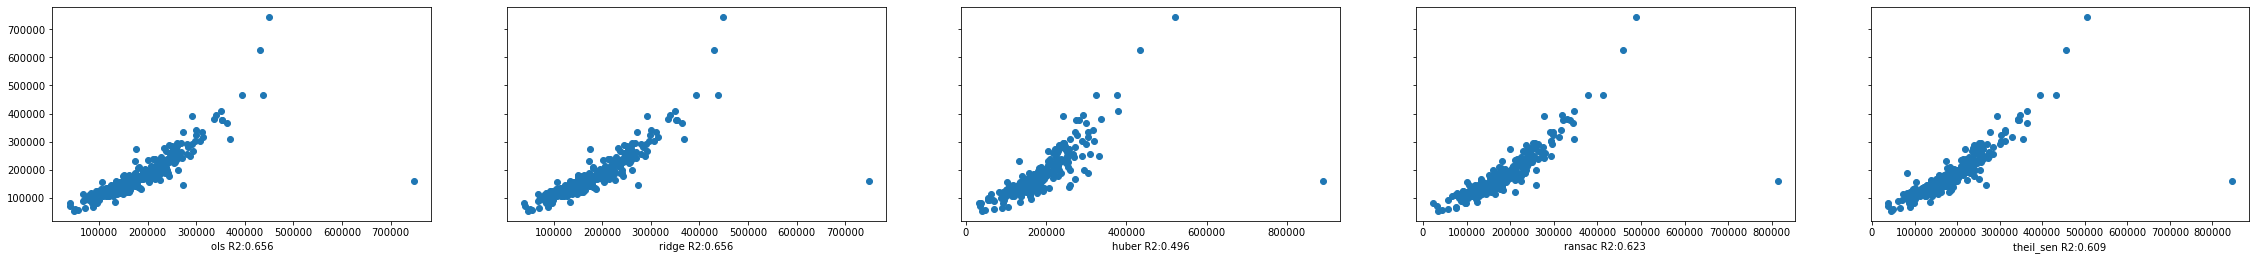

In [680]:
X_train_D, y_train_D = split(train_dropped_encoded)
X_test_D, y_test_D = split(test_dropped_encoded)

result = run_lin_regression(X_train_D, y_train_D, X_test_D, y_test_D)
plot_predictions(result, y_test_D, fig_name_info='_dropped')

### 3.3.2 On Imputed data

Root Mean Squared Error: 47726.292
Coefficient of determination: 0.660
Root Mean Squared Error: 47727.024
Coefficient of determination: 0.660


C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Root Mean Squared Error: 48224.725
Coefficient of determination: 0.653
Root Mean Squared Error: 72107.721
Coefficient of determination: 0.225
Root Mean Squared Error: 50856.444
Coefficient of determination: 0.614


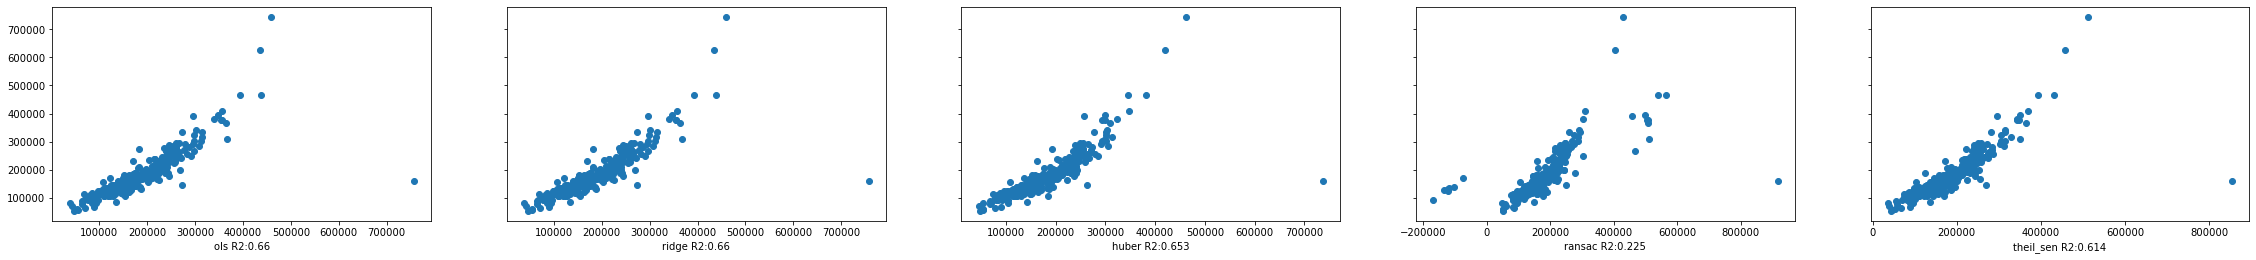

In [681]:
X_train_I, y_train_I = split(train_imputed_encoded)
X_test_I, y_test_I = split(test_imputed_encoded)

result = run_lin_regression(X_train_I, y_train_I, X_test_I, y_test_I) # why does this shit out on huber?
plot_predictions(result, y_test_I, fig_name_info='_imputed')

### 3.3.3 On dropped and unskewed data

Root Mean Squared Error: 0.106
Coefficient of determination: 0.813
Root Mean Squared Error: 0.107
Coefficient of determination: 0.809


C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Root Mean Squared Error: 0.114
Coefficient of determination: 0.783
Root Mean Squared Error: 0.115
Coefficient of determination: 0.779
Root Mean Squared Error: 0.142
Coefficient of determination: 0.661


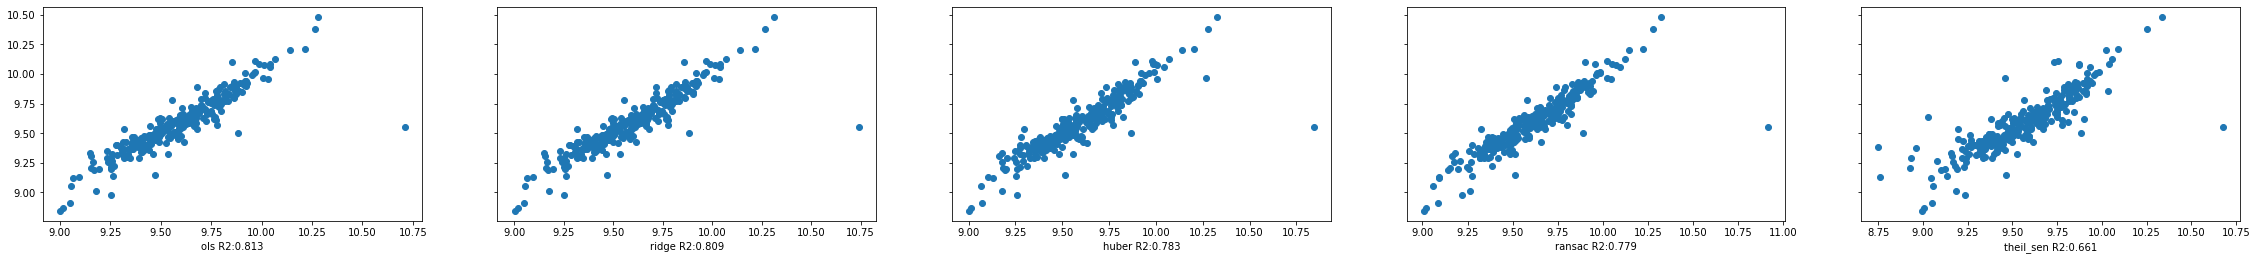

In [682]:
X_train_DU, y_train_DU = split(train_dropped_unskewed_encoded)
X_test_DU, y_test_DU = split(test_dropped_unskewed_encoded)

result = run_lin_regression(X_train_DU, y_train_DU, X_test_DU, y_test_DU) # why does this shit out on huber?
plot_predictions(result, y_test_DU, fig_name_info='_dropped_unskewed')

### 3.3.3 On Imputed and unskewed data

Root Mean Squared Error: 0.090
Coefficient of determination: 0.818
Root Mean Squared Error: 0.091
Coefficient of determination: 0.815


C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Root Mean Squared Error: 0.100
Coefficient of determination: 0.777
Root Mean Squared Error: 0.180
Coefficient of determination: 0.276
Root Mean Squared Error: 0.171
Coefficient of determination: 0.348


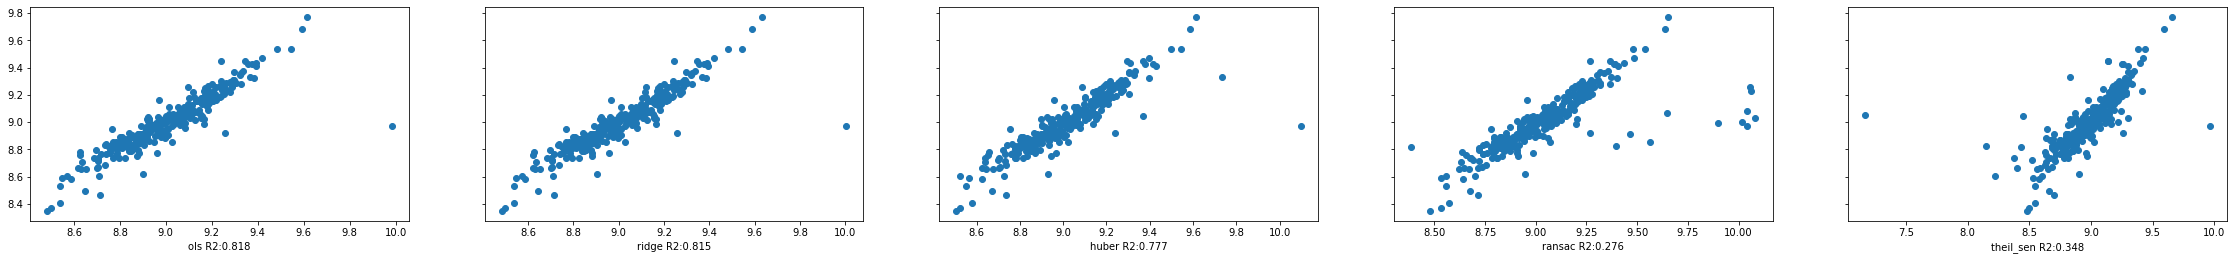

In [683]:
X_train_IU, y_train_IU = split(train_imputed_unskewed_encoded)
X_test_IU, y_test_IU = split(test_imputed_unskewed_encoded)

result = run_lin_regression(X_train_IU, y_train_IU, X_test_IU, y_test_IU) # why does this shit out on huber?
plot_predictions(result, y_test_IU, fig_name_info='_imputed_unskewed')

# 4. Questions

## Task 1 
Apply two techniques to handle missing data
Justify why these two techniques were chosen
compare the regression model's performance on the two data sets

## Task 2
 Write Python code to build a regression model from the training set that you applied the better
solution in (1). Write the code to evaluate its performance on the test set that you applied the better
solution in (1) with Root-Mean-Squared-Error (RMSE). RMSE shares similar motivation of the least
square loss we taught in the lecture. Section 5 gives reference for the definition. Please try at least
two regression models and compare their performances.  

## Task 3
There are 38 features provided for each house. Are all of the features used in your regression
models? What’s the impact if removing some features? Please write your own code to compare
different feature selections and justify your selection. At least two feature selections are investigated
(full feature set, a subset of the features). The dataset is the modified ones that you applied the
better solution in (1). (6 Marks)

In [686]:
def create_data_subset(X_train, X_test, columns_to_drop):
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    for column in columns_to_drop:
        X_train_copy = X_train_copy.drop([column], axis=1)
        X_test_copy = X_test_copy.drop([column], axis=1)
    return X_train_copy, X_test_copy

In [687]:
# drop ID because it contains no information about the house
# drop MSsubclass because the that information is repeated in the categoricals anyway with more fidelity
# drop MoSold - assume no seasonal price trends
# drop MiscVal - seems immaterial
# drop Fireplaces - seems incidental to the house sale

# query is sale price adjusted for inflation?

columns_to_drop = ['ID', 'MSSubClass', 'MoSold', 'MiscVal', 'Fireplaces', 'PoolArea'] # Removing these feature = no change in coef. determin. 0.817 of ransac regression

Root Mean Squared Error: 0.091
Coefficient of determination: 0.816
Root Mean Squared Error: 0.091
Coefficient of determination: 0.815


C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Root Mean Squared Error: 0.106
Coefficient of determination: 0.746
Root Mean Squared Error: 0.099
Coefficient of determination: 0.780
Root Mean Squared Error: 0.175
Coefficient of determination: 0.313


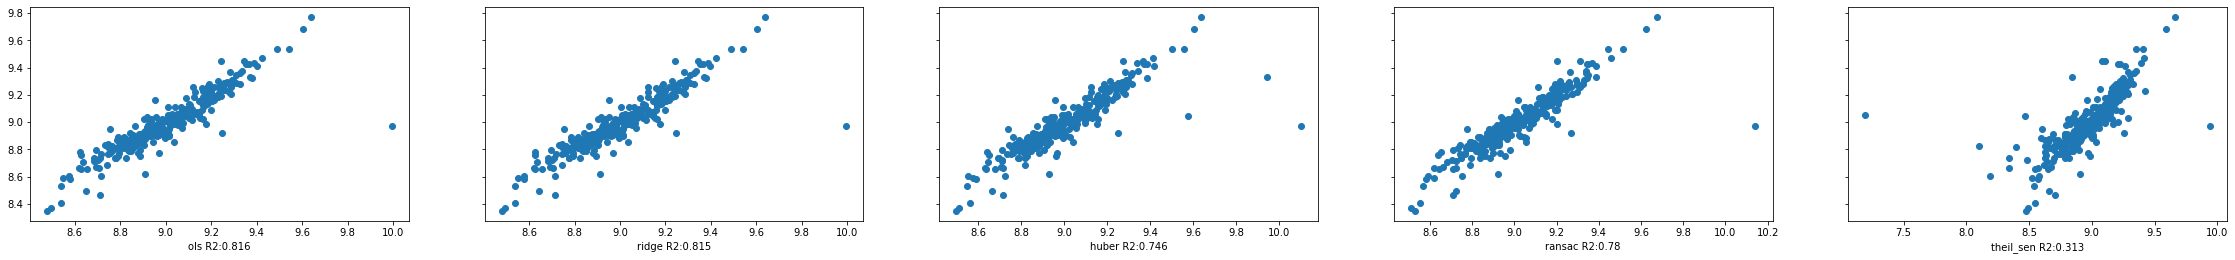

In [688]:
X_train_IUD, X_test_IUD= create_data_subset(X_train_IU, X_test_IU, columns_to_drop)

result = run_lin_regression(X_train_IUD, y_train_IU, X_test_IUD, y_test_IU)
plot_predictions(result, y_test_IU, fig_name_info='_imputed_unskewed_extraDrops')

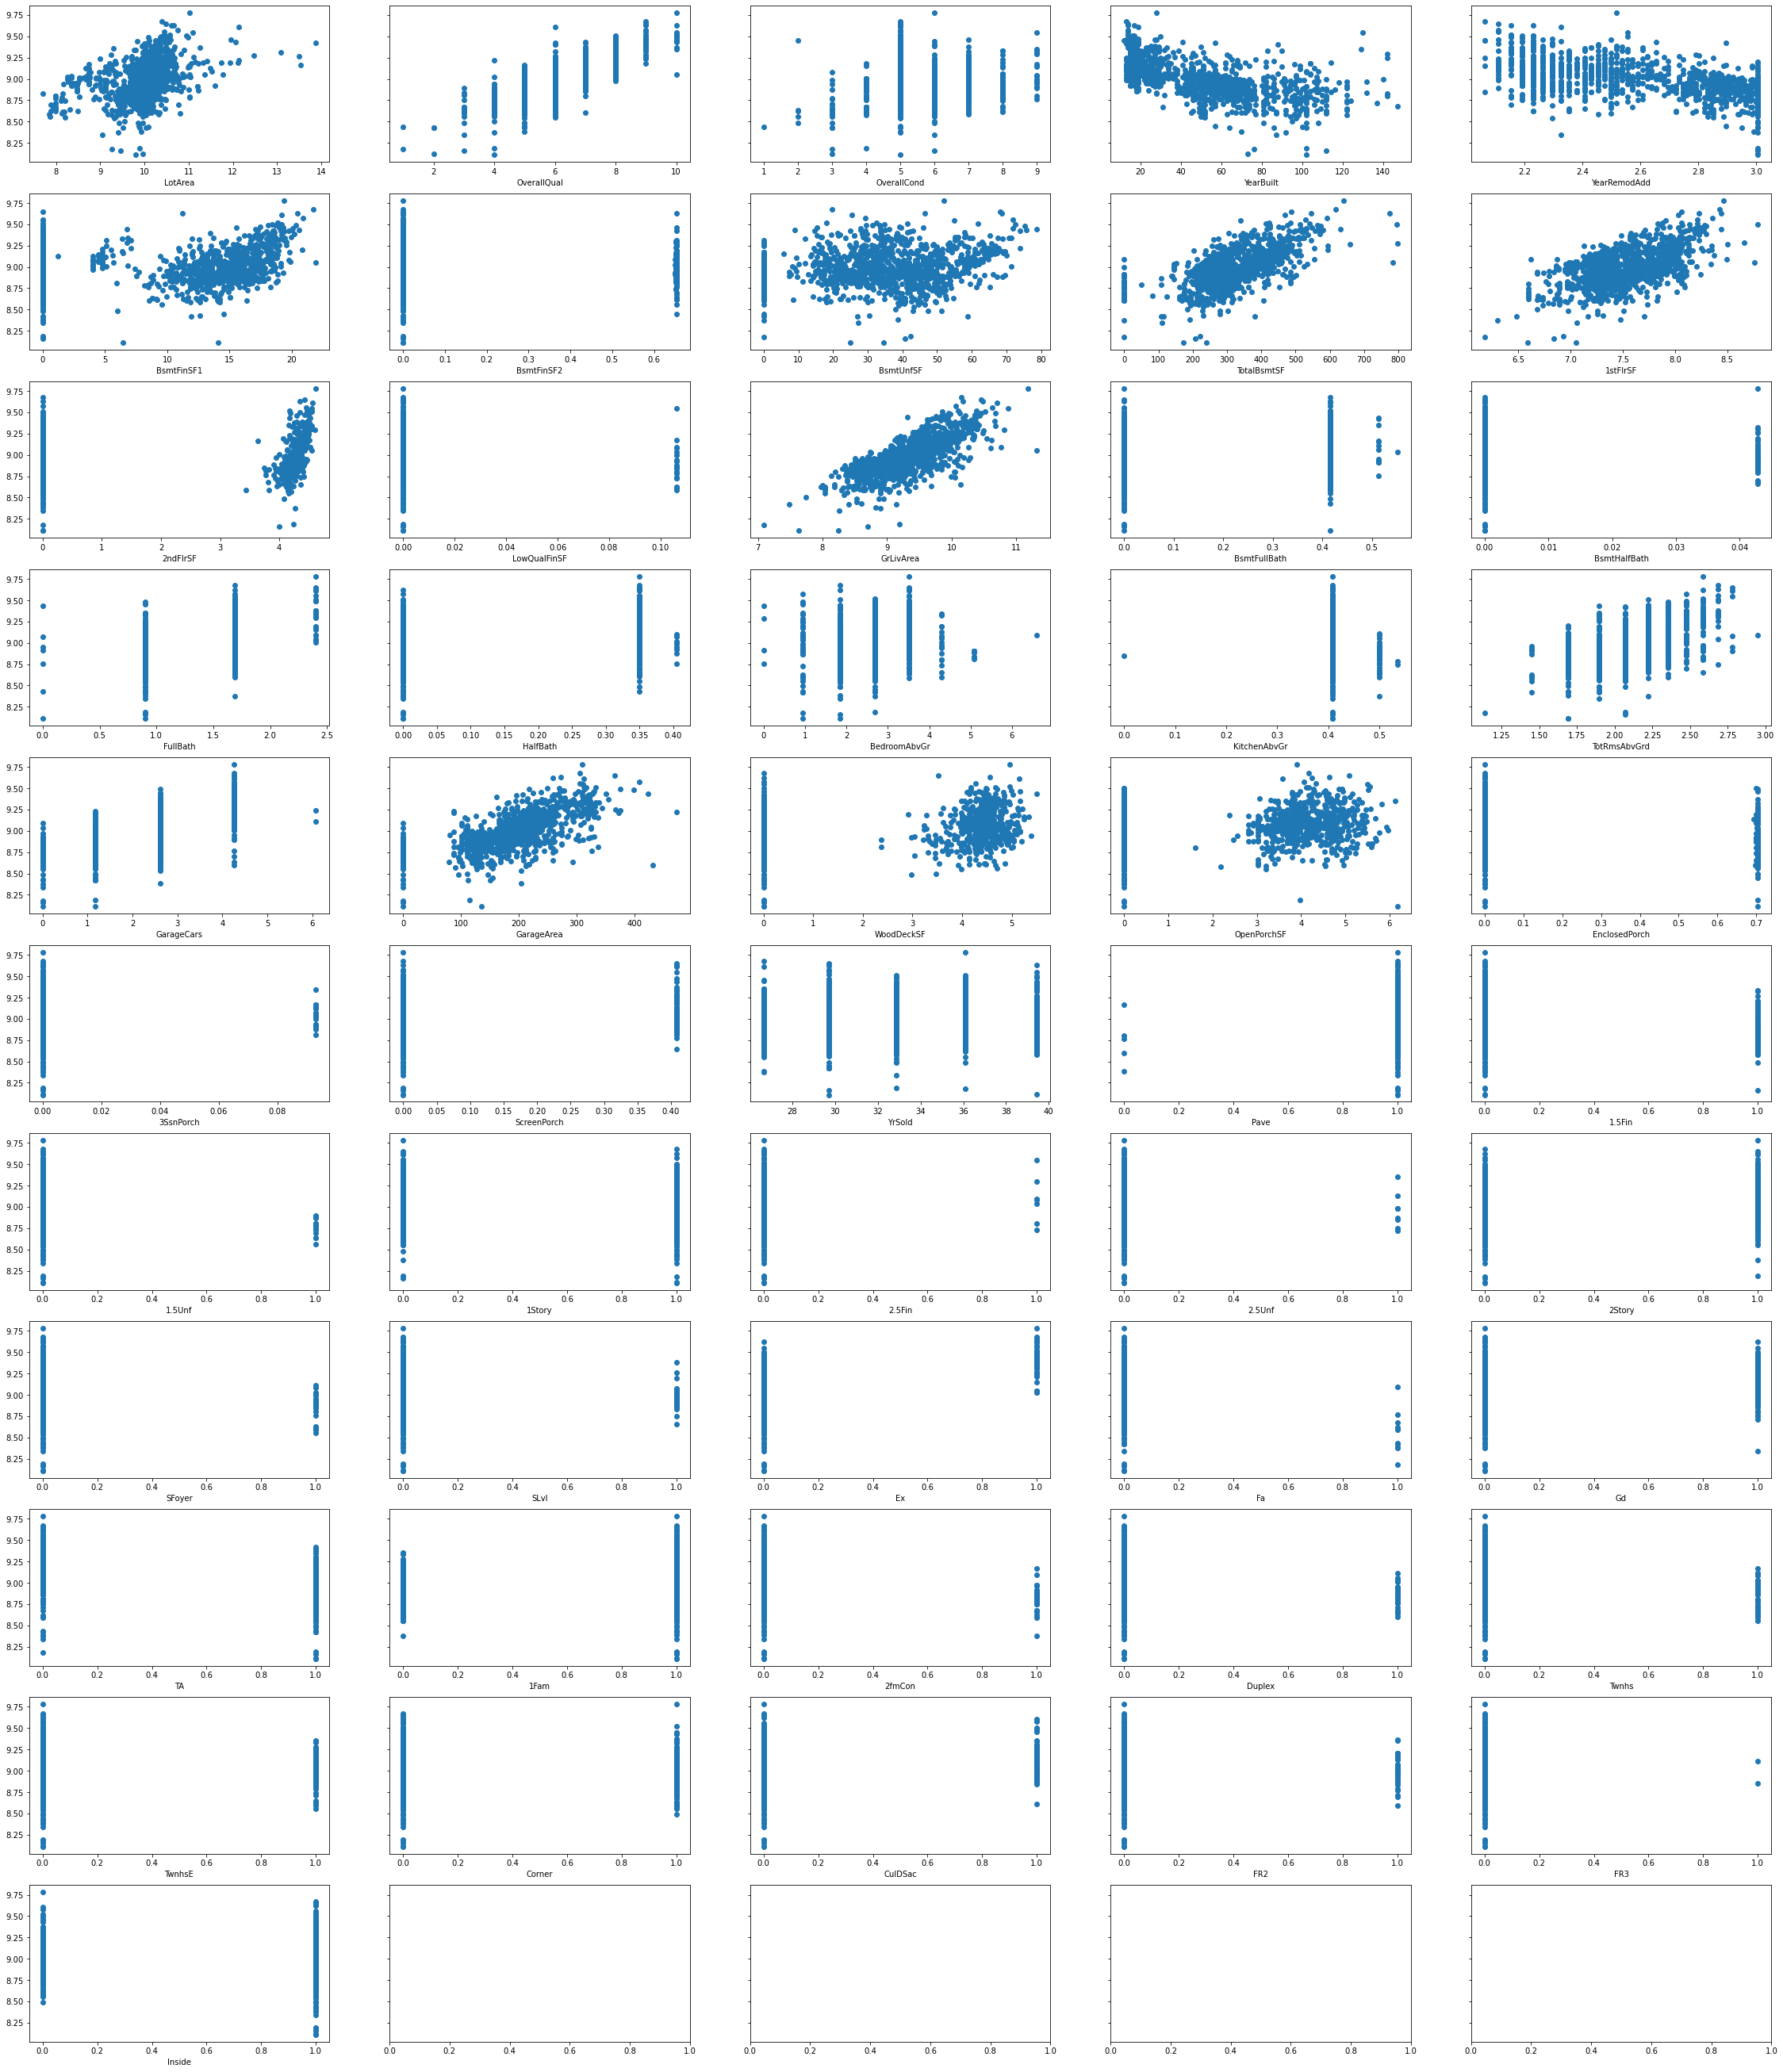

In [689]:
plot_custom_subplot(X_train_IUD, y_train_IU)

<AxesSubplot:>

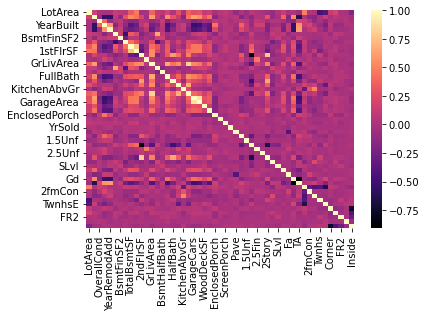

In [690]:
sb.heatmap(X_train_IUD.corr(), cmap = 'magma')